# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict
import scipy.stats as stats

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [3]:
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]

# drop the customers with less than 5 unique MCCs, to better represent the customer's spending habits
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data.groupby('customerId')['MCC_List'].nunique()>4)]

# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

In [4]:
proportion_matrix = filtered_data.groupby(['customerId','MCC_List'])['amount.value'].sum().unstack().fillna(0).div(filtered_data.groupby('customerId')['amount.value'].sum(), axis=0).fillna(0)
proportion_matrix.head()

MCC_List                              Advertising Services  Aer Lingus  \
customerId                                                               
01968de9-41cb-4509-b0a6-6bdc02700150                   0.0         0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                   0.0         0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                   0.0         0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                   0.0         0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                   0.0         0.0   

MCC_List                              Airlines and Air Carriers  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                        0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                        0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                        0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                        0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                        0.0   

MCC_List                              Airports, Flying Fields, and Airport Terminals   \
customerId                                                                              
01968de9-41cb-4509-b0a6-6bdc02700150                                              0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                              0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                              0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                              0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                              0.0   

MCC_List                              Amusement Parks, Circuses, Carnivals, and Fortune Tellers   \
customerId                                                                                         
01968de9-41cb-4509-b0a6-6bdc02700150                                                0.0            
01b34ce5-ce43-4c2d-a73d-5294376bd399                                                0.0            
01b4698f-32be-4bc0-9b69-b3024ac18004                                                0.0            
01ef943c-d661-48b0-9c0b-bb456a7d998d                                                0.0            
03025a2b-9179-4da9-8dff-af4a3179ce7f                                                0.0            

MCC_List                              Antique Shop  \
customerId                                           
01968de9-41cb-4509-b0a6-6bdc02700150           0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399           0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004           0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d           0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f           0.0   

MCC_List                              Aquarium, Seaquarium, Dolphinariums  \
customerId                                                                  
01968de9-41cb-4509-b0a6-6bdc02700150                                  0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                                  0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                                  0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                                  0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                                  0.0   

MCC_List                              Art Dealers and Galleries  \
customerId                                                        
01968de9-41cb-4509-b0a6-6bdc02700150                        0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                        0.0   
01b4698f-32be-4bc0-9b69-b3024ac18004                        0.0   
01ef943c-d661-48b0-9c0b-bb456a7d998d                        0.0   
03025a2b-9179-4da9-8dff-af4a3179ce7f                        0.0   

MCC_List                              Artist Supply and Craft Stores  \
customerId                                                             
01968de9-41cb-4509-b0a6-6bdc02700150                             0.0   
01b34ce5-ce43-4c2d-a73d-5294376bd399                             0.0   
01b4698f-

In [5]:
connection_list = proportion_matrix.stack().reset_index()
connection_list.columns = ['customerId', 'MCC_List', 'connection']
connection_list = connection_list[connection_list['connection'] != 0]
connection_list.reset_index(drop=True, inplace=True)
connection_list

customerId  \
0     01968de9-41cb-4509-b0a6-6bdc02700150   
1     01968de9-41cb-4509-b0a6-6bdc02700150   
2     01968de9-41cb-4509-b0a6-6bdc02700150   
3     01968de9-41cb-4509-b0a6-6bdc02700150   
4     01968de9-41cb-4509-b0a6-6bdc02700150   
...                                    ...   
4199  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4200  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4201  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4202  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4203  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   

                                         MCC_List  connection  
0                                        Bakeries    0.002742  
1                         Beauty and Barber Shops    0.010963  
2         Bus Lines, includes Charters/Tour Buses    0.007739  
3            Candy, Nut, and Confectionary Stores    0.001062  
4                   Caterers - Prepare & Delivery    0.003133  
...                                           ...         ...  
4199                                  Shoe Stores    0.011356  
4200             Sporting and Recreational Camps     0.003852  
4201  Stationery, Office and School Supply Stores    0.005890  
4202             Tourist Attractions and Exhibits    0.000526  
4203                  Video Amusement Game Supply    0.000342  

[4204 rows x 3 columns]

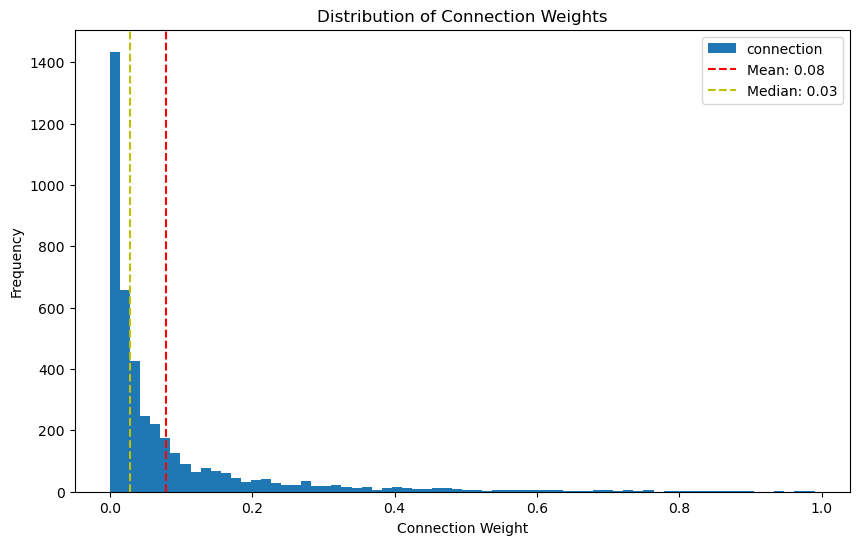

In [6]:
# plot the distribution of the connnection weights (proportion of mcc frequency)
data = connection_list['connection']
mean_value = np.mean(data)
median_value = np.median(data)
std_value = np.std(data)

plt.figure(figsize=(10, 6))
# sns.histplot(data, bins=50, kde=True)
data.plot(kind='hist', bins=70)
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='y', linestyle='--', label=f'Median: {median_value:.2f}')

plt.title('Distribution of Connection Weights')
plt.xlabel('Connection Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
data = connection_list['connection']
print('Mean:', np.mean(data))
print('Median:', np.median(data))
print('Max:', np.max(data))
print('Min:', np.min(data))

Mean: 0.07921027592768792
Median: 0.028765792927482523
Max: 0.9901233153583674
Min: 0.00010104307544031463


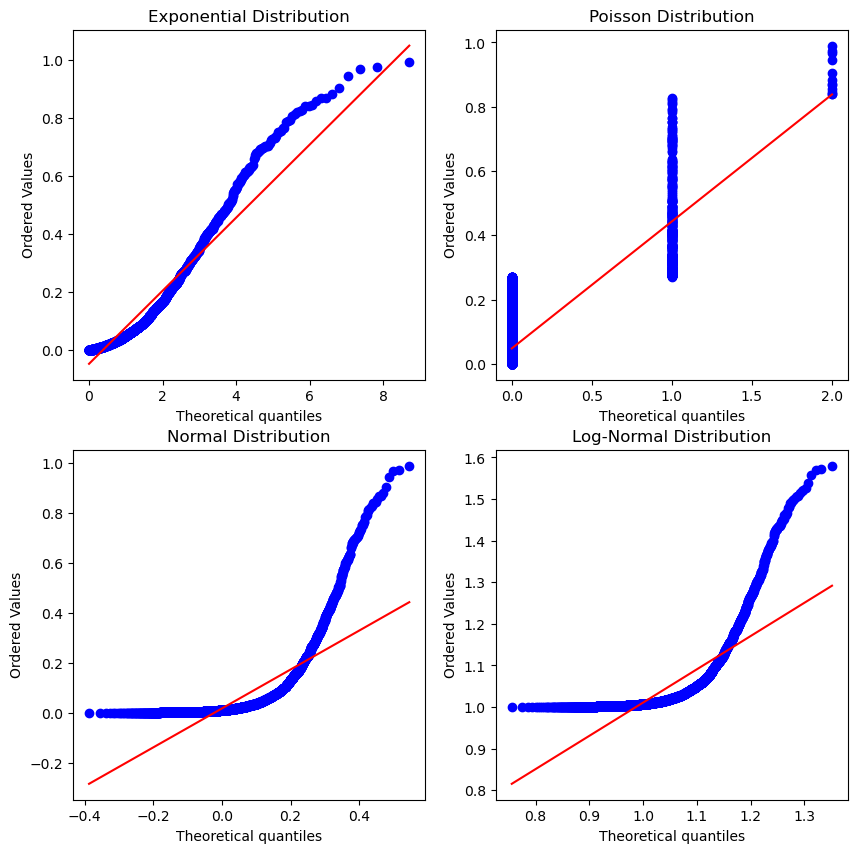

In [8]:
# plot the qq plot of frequency with the exponential distribution, normal distribution, and poisson distribution

# all plots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

data = connection_list['connection']

# Exponential distribution
stats.probplot(data, dist="expon", plot=axs[0, 0])
axs[0, 0].set_title('Exponential Distribution')

# Poisson distribution
mu = data.mean()
stats.probplot(data, dist="poisson", sparams=(mu,), plot=axs[0, 1])
axs[0, 1].set_title('Poisson Distribution')

# Normal distribution
mu, std = stats.norm.fit(data)

stats.probplot(data, dist="norm", sparams=(mu, std), plot=axs[1, 0])
axs[1, 0].set_title('Normal Distribution')

# log-normal distribution
mu, std = stats.norm.fit(np.log2(data+2))
stats.probplot(np.log2(data+2), dist="norm", sparams=(mu, std), plot=axs[1, 1])
axs[1, 1].set_title('Log-Normal Distribution')
plt.show()

cvm Statistics:  73.2972838810631 , p-value:  0.0001


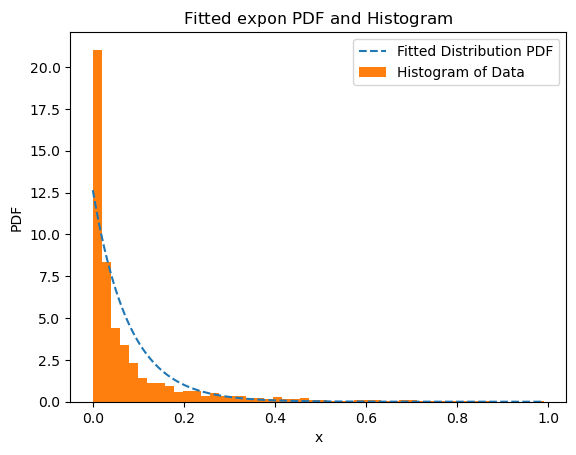

In [9]:
rng = np.random.default_rng(seed=41)

data = connection_list['connection']
loc, scale = stats.expon.fit(data)

known_params = {'loc': loc, 'scale': scale}
method = 'cvm'
# method = 'filliben'
# method = 'ad'
# method = 'ks'

res = stats.goodness_of_fit(stats.expon, data, known_params=known_params,
                            random_state=rng, statistic=method)
print("cvm Statistics: ", res.statistic, ", p-value: ", res.pvalue)
res.fit_result.plot()
plt.show()

# build a network

In [9]:
connection_list

customerId  \
0     01968de9-41cb-4509-b0a6-6bdc02700150   
1     01968de9-41cb-4509-b0a6-6bdc02700150   
2     01968de9-41cb-4509-b0a6-6bdc02700150   
3     01968de9-41cb-4509-b0a6-6bdc02700150   
4     01968de9-41cb-4509-b0a6-6bdc02700150   
...                                    ...   
4199  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4200  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4201  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4202  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   
4203  ffcf3506-a7d8-48a0-ba54-d4d54d15ee78   

                                         MCC_List  connection  
0                                        Bakeries    0.002742  
1                         Beauty and Barber Shops    0.010963  
2         Bus Lines, includes Charters/Tour Buses    0.007739  
3            Candy, Nut, and Confectionary Stores    0.001062  
4                   Caterers - Prepare & Delivery    0.003133  
...                                           ...         ...  
4199                                  Shoe Stores    0.011356  
4200             Sporting and Recreational Camps     0.003852  
4201  Stationery, Office and School Supply Stores    0.005890  
4202             Tourist Attractions and Exhibits    0.000526  
4203                  Video Amusement Game Supply    0.000342  

[4204 rows x 3 columns]

In [11]:
# build a weighted network
g = gt.Graph(directed=False)
# difine the node properties
## name: docs - title, words - 'word'
## kind: docs(customers) - 0, words(mcc) - 1
name = g.vp['name'] = g.new_vp('string')
kind = g.vp['kind'] = g.new_vp('int')
## define the edge properties
weight = g.ep['weight'] = g.new_ep('double')

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

for _, row in connection_list.iterrows():
    customer = row['customerId']
    mcc = row['MCC_List']
    weight = row['connection']
    # add customer node
    docs = docs_add[customer]
    name[docs] = customer
    kind[docs] = 0
    # add mcc node
    words = words_add[mcc]
    name[words] = mcc
    kind[words] = 1
    edge = g.edge(docs, words)
    if edge is None:
        edge = g.add_edge(docs, words)
        g.ep['weight'][edge] = 0
    g.ep['weight'][edge] += weight

# Nested SBM

In [10]:
SEED = 41
n_init = 50

In [13]:
gt.seed_rng(SEED)

clabel = g.vp['kind']

state_args = {'clabel': clabel
              , 'pclabel': clabel
              # , 'eweight': g.ep['weight']
              , 'recs':[g.ep['weight']]
              , 'rec_types': ['real-exponential']
            #   , 'rec_types': ['real-normal']
              }

mdl = np.inf
for i_n_init in range(n_init):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(g
                                                 ,state_args=dict(base_type=base_type,**state_args)
                                                 ,multilevel_mcmc_args=dict(niter=1, verbose=False)
                                                 )
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])
    print(state_tmp.entropy())

    mdl_tmp = state_tmp.entropy()
    if mdl_tmp < mdl:
        mdl = 1.0*mdl_tmp
        state = state_tmp.copy()

g.state = state

g.mdl = state.entropy()
L = len(state.levels)
if L == 2:
    g.L = 1
else:
    g.L = L-2

245.2415786477796
144.65260717163093
-10.800115550922015
1.7762401080049433
-65.64055422190856
92.35775756724425
-96.1086589213509
-84.75819489166079
391.0837329939009
-105.66639694549875
128.78931306473064
-64.60597119049024
-76.9514387631946
-45.154510651830094
-20.506493148022656
64.6907703601
-66.45576168454019
-18.48319628105898
37.00443615776496
-26.211234404460043
22.583569242307846
69.56512570820914
69.81720753063561
-32.22957904894287
37.93935029974611
86.22582332894157
40.191612033892596
-75.76812069511035
-73.37974297453505
-99.5039974112922
-36.03325090131838
-44.084898826637044
91.98719788612996
16.60542657563397
59.71838514124778
-82.08588880664368
401.28671213883047
-22.13750055718188
-65.57163400500306
-112.75467879976944
-67.46970672247525
-41.4843340726371
-3.1065555253825607
0.9614350487688359
-8.546271559078008
89.34443245312653
-15.570234229517808
14.559344263797046
-61.984522261202486
85.86684294723389


In [14]:
print('The lowest entropy was {}, and the state has {} blocks at level 1'.format(g.state.entropy(),g.state.get_levels()[1].get_nonempty_B()))

The lowest entropy was -112.75467879976944, and the state has 13 blocks at level 1


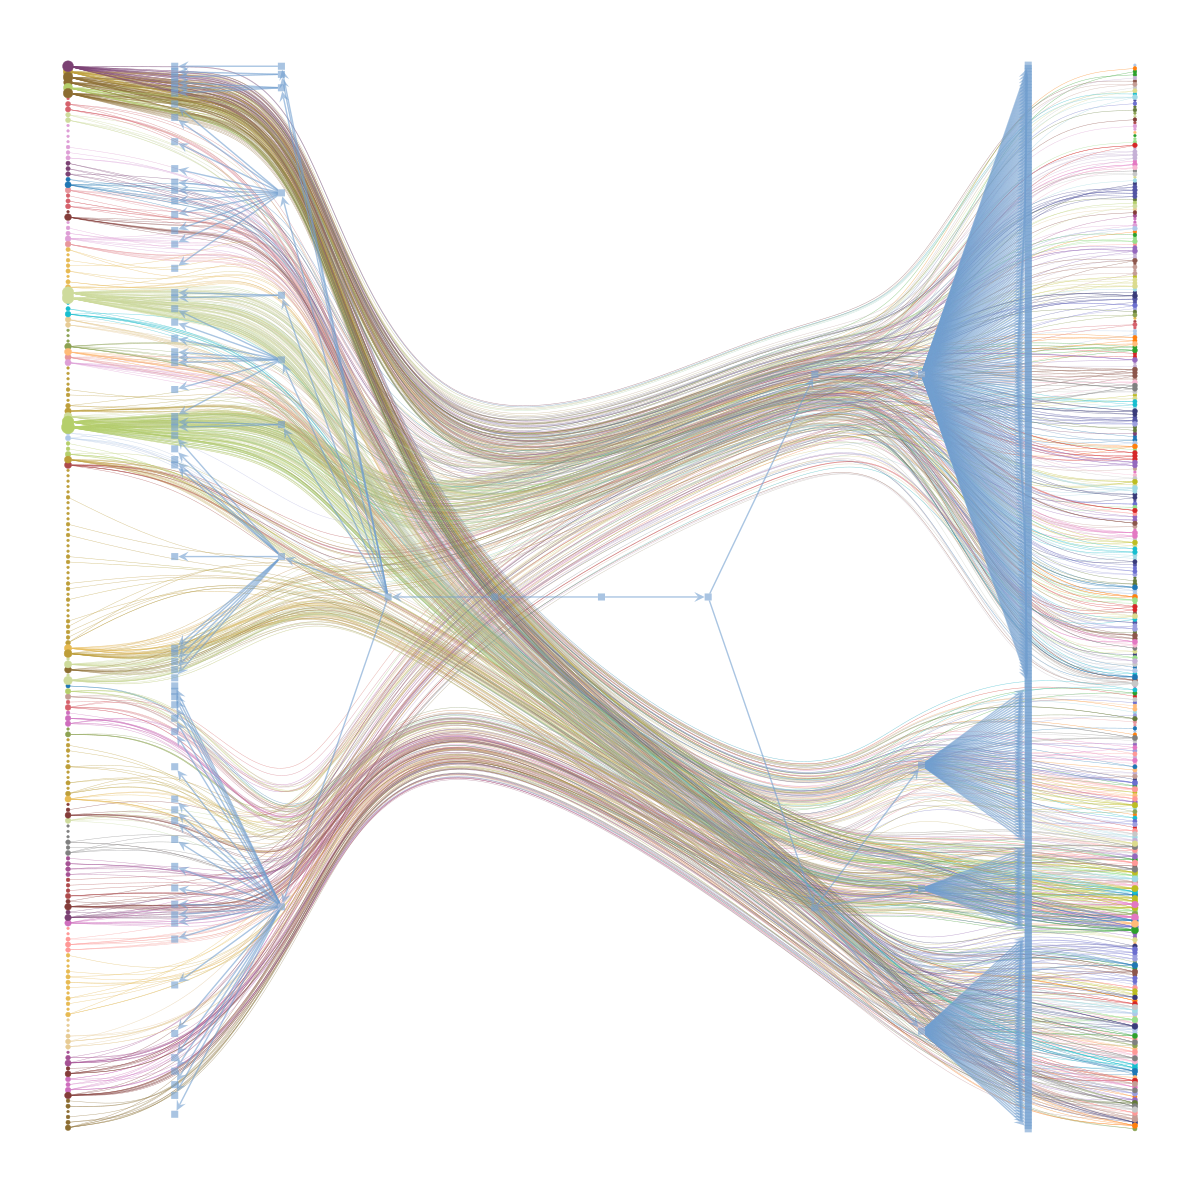

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3ec8349c40, at 0x7f3ec83d41d0>,
 <GraphView object, directed, with 946 vertices and 945 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f3ec9f64a40, at 0x7f3ec9f67d10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f3ec9f64a40, at 0x7f3ec92782c0>, False), at 0x7f3ec9f64a40>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3ec9f64a40, at 0x7f3ec92ee0f0>)

In [15]:
g.state.draw(
    layout='bipartite'
    ,subsample_edges=1000, hshortcuts=1, hide=0
    ,hvprops={'size':5}
    ,heprops={'pen_width':0.7}
)

### save the network

In [16]:
with open('w_amount_proportion_graph_s{}_n{}.pkl'.format(SEED, n_init), 'wb') as f:
    pickle.dump(g, f)
with open('w_amount_proportion_state_s{}_n{}.pkl'.format(SEED, n_init), 'wb') as f:
    pickle.dump(g.state, f)

### load the network

In [68]:
with open('w_amount_proportion_graph_s{}_n{}.pkl'.format(SEED, n_init), 'rb') as f:
    model = pickle.load(f)
with open('w_amount_proportion_state_s{}_n{}.pkl'.format(SEED, n_init), 'rb') as f:
    model.state = pickle.load(f)

In [69]:
model.state.entropy()

-112.75467879976944

In [70]:
SEED = 41
gt.seed_rng(SEED)

In [71]:
starting_entropy = model.state.entropy()
entropy_gain_multiflip = [model.state.multiflip_mcmc_sweep(beta=np.inf, niter=20)[0] for _ in range(1000)]

In [72]:
model.state.entropy()

-488.91584950995014

In [35]:
with open('w_amount_proportion_graph_s{}_n{}_sweeped.pkl'.format(SEED, n_init), 'wb') as f:
    pickle.dump(model, f)
with open('w_amount_proportion_state_s{}_n{}_sweeped.pkl'.format(SEED, n_init), 'wb') as f:
    pickle.dump(model.state, f)

In [73]:
entropy_diff = np.cumsum(np.array(entropy_gain_multiflip))
entropy_diff_positive = -entropy_diff

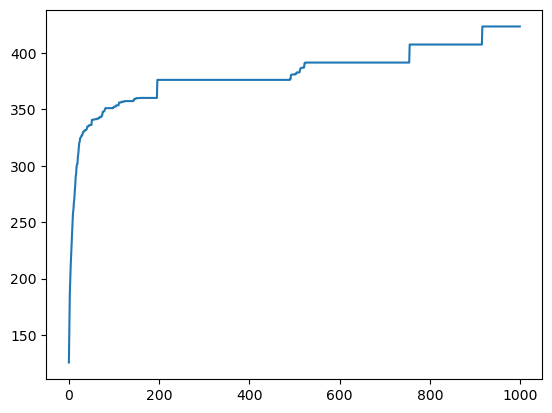

In [74]:
plt.plot(entropy_diff_positive)

### load the sweeped network

In [191]:
with open('w_amount_proportion_graph_s{}_n{}_sweeped.pkl'.format(SEED, n_init), 'rb') as f:
    model = pickle.load(f)
with open('w_amount_proportion_state_s{}_n{}_sweeped.pkl'.format(SEED, n_init), 'rb') as f:
    model.state = pickle.load(f)

In [192]:
model.state.entropy()

-527.4864318710734

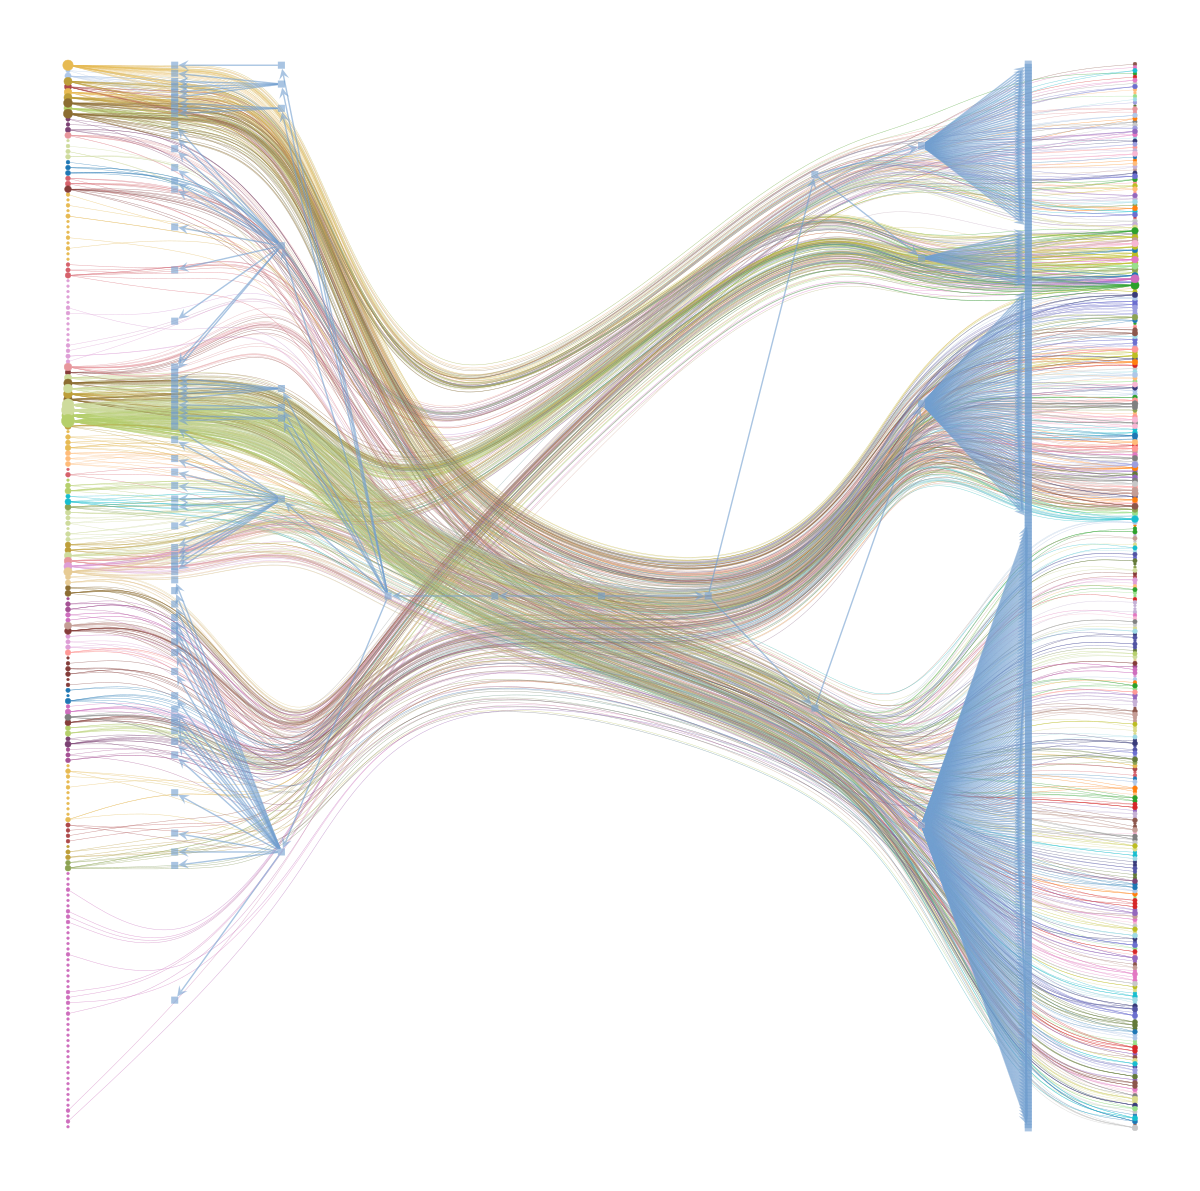

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd6ac6dc110, at 0x7fd6a7511070>,
 <GraphView object, directed, with 946 vertices and 945 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fd6a7512d80, at 0x7fd6a59db1d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fd6a7512d80, at 0x7fd6a59d8fb0>, False), at 0x7fd6a7512d80>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fd6a7512d80, at 0x7fd6a67174a0>)

In [75]:
model.state.draw(
    layout='bipartite'
    ,subsample_edges=1000, hshortcuts=1, hide=0
    ,hvprops={'size':5}
    ,heprops={'pen_width':0.7}
)

In [76]:
state_l0 = model.state.project_level(0).copy()
state_l1 = model.state.project_level(1).copy()

In [77]:
b0 = gt.contiguous_map(state_l0.b)
b1 = gt.contiguous_map(state_l1.b)
label_map = {}
for v in model.vertices():
    label_map[state_l0.b[v]] = b0[v]
state_l0 = state_l0.copy(b=b0)
state_l1 = state_l1.copy(b=b1)

In [78]:
# create a dict for nodes and their blocks
blocks = {}
for v in model.vertices():
    blocks[model.vp['name'][v]] = [model.vp['kind'][v], state_l1.get_blocks()[v], state_l0.get_blocks()[v]]

In [212]:
df_clusters = pd.DataFrame.from_dict(blocks, orient='index', columns=['kind', 'level_1', 'level_0']).reset_index()
df_clusters = df_clusters.rename(columns={'index':'node'})
df_clusters['node'] = df_clusters['node'].astype(str)
df_clusters['levels'] = df_clusters['level_1'].astype(str) + '_' + df_clusters['level_0'].astype(str)
df_clusters.sort_values(by=['kind','level_1','level_0'], ascending=True, inplace=True)
df_clusters = df_clusters[df_clusters['kind'] == 0].reset_index(drop=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

node  kind  level_1  level_0  levels
0    01968de9-41cb-4509-b0a6-6bdc02700150     0        0        0     0_0
1    2aa2a980-470d-470a-8379-ec51e5036ee4     0        0      112   0_112
2    3253926e-9c0d-4fd9-8248-eb7c2f457b99     0        0      118   0_118
3    34f30c26-4ab6-4b64-94f2-ccdf4cd0b1c1     0        0      122   0_122
4    40145ab5-241c-47c5-bb6a-3a05374b28a9     0        0      134   0_134
..                                    ...   ...      ...      ...     ...
328  eb6043b4-9a96-4552-95ac-8fc53a176e90     0       12      367  12_367
329  ec69f89b-b0ed-4bea-9092-1484b9139f64     0       12      368  12_368
330  f601e896-6666-4ff6-a6d0-4748d1412f24     0       12      379  12_379
331  fbfdc807-2e8c-40b6-bb49-c3a02da2c8c1     0       12      387  12_387
332  feb37e88-b280-40b8-b887-30961016417c     0       12      393  12_393

[333 rows x 5 columns]

In [80]:
df_clusters['level_0'].nunique()

333

In [20]:
df_clusters['levels'].unique()

array(['0_0', '0_112', '0_118', '0_122', '0_134', '0_135', '0_156',
       '0_161', '0_176', '0_202', '0_216', '0_226', '0_230', '0_240',
       '0_248', '0_257', '0_270', '0_271', '0_272', '0_274', '0_276',
       '0_279', '0_301', '0_322', '0_350', '0_392', '0_395', '9_33',
       '9_54', '9_82', '9_90', '9_93', '9_104', '9_107', '9_109', '9_113',
       '9_117', '9_126', '9_141', '9_148', '9_153', '9_155', '9_158',
       '9_160', '9_166', '9_179', '9_180', '9_185', '9_186', '9_212',
       '9_222', '9_231', '9_238', '9_239', '9_249', '9_258', '9_265',
       '9_269', '9_281', '9_283', '9_287', '9_293', '9_298', '9_314',
       '9_317', '9_321', '9_325', '9_341', '9_352', '9_357', '9_361',
       '9_366', '9_368', '9_370', '9_379', '9_387', '9_393', '10_37',
       '10_41', '10_55', '10_57', '10_60', '10_64', '10_71', '10_72',
       '10_75', '10_76', '10_77', '10_79', '10_80', '10_81', '10_83',
       '10_88', '10_89', '10_91', '10_94', '10_95', '10_96', '10_98',
       '10_100', '

Cluster 0: 18
Cluster 10: 190
Cluster 11: 73
Cluster 12: 52


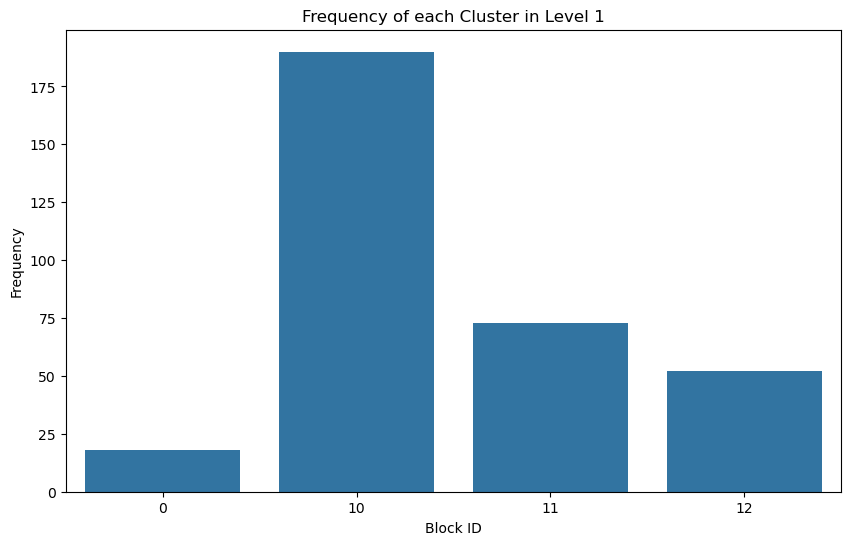

In [388]:
# calculate the frequency of each block and sort them by the id of the block
block_freq = {}
l=1
for i in df_clusters['level_{}'.format(l)].unique():
    # block_freq[str(i)] = len([x for x in b if x == i])
    block_freq[i] = len(df_clusters[df_clusters['level_{}'.format(l)] == i])
    print('Cluster {}: {}'.format(i, block_freq[i]))
# plot the frequency of each block
plt.figure(figsize=(10, 6))
sns.barplot(x=list(block_freq.keys()), y=list(block_freq.values()))
plt.xlabel('Block ID')
plt.ylabel('Frequency')
plt.title('Frequency of each Cluster in Level {}'.format(l))
plt.show()

## Heatmaps of Purchases by Cluster

In [82]:
df_clusters.head()

node  kind  level_1  level_0 levels
0  01968de9-41cb-4509-b0a6-6bdc02700150     0        0        0    0_0
1  2aa2a980-470d-470a-8379-ec51e5036ee4     0        0      112  0_112
2  3253926e-9c0d-4fd9-8248-eb7c2f457b99     0        0      118  0_118
3  34f30c26-4ab6-4b64-94f2-ccdf4cd0b1c1     0        0      122  0_122
4  40145ab5-241c-47c5-bb6a-3a05374b28a9     0        0      134  0_134

In [185]:
# new version: average of mcc proportion of each customer -> population average mcc proportion
def heatmaps_new(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        if len(xvalues) == 2:
            annot = False
        else:
            annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = filtered_data.groupby('customerId')['y'].value_counts(normalize=True).unstack().fillna(0)
        df_mcc_avg = df_avg.mean().reset_index().set_index('y').sort_values(0, ascending=False)
        # df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        # df['count'] = 1
    elif value == 'amount':
        df_avg = filtered_data.groupby(['customerId','y'])['amount.value'].sum().unstack().fillna(0).div(filtered_data.groupby('customerId')['amount.value'].sum(), axis=0).fillna(0)
        df_mcc_avg = df_avg.mean().reset_index().set_index('y').sort_values(0, ascending=False)
        # df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        # df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df_avg[df_avg.index.isin(custid)]
        cluster_avg = filtered_df.mean()
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log(cluster_avg/df_mcc_avg[0]).rename(cluster)
        else:
            counts = cluster_avg.rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_mcc_avg.index = df_mcc_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    data = df_data.values
    finite_data = data[np.isfinite(data)]
    mu, std = stats.norm.fit(finite_data)
    limit = 2*std
    # print('Mean:', mu)
    # print('Std:', std)
    # min = finite_data[np.isfinite(finite_data)].min()
    # max = finite_data[np.isfinite(finite_data)].max()
    # limit = np.max([np.abs(min), max])
    # print('Limit:', limit)

    # shows only the top mcc if topn is given
    if topn:
        if len(yvalues) == 2:
            df_mcc_avg = df_avg.mean().reset_index().set_index('y').sort_values(0, ascending=False)
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_mcc_avg.nlargest(topn, df_mcc_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(20, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-5, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='black', lw=0.5, linestyle='--', alpha=0.7)
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

In [63]:
# old version: proportion of sum value of mcc -> population average mcc proportion
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        if len(xvalues) == 2:
            annot = False
        else:
            annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(20, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5
                    , vmin=-limit, vmax=limit
                    # , center=0
                    , yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-5, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='black', lw=0.5, linestyle='--', alpha=0.7)
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

/home/weiz/anaconda3/envs/network/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


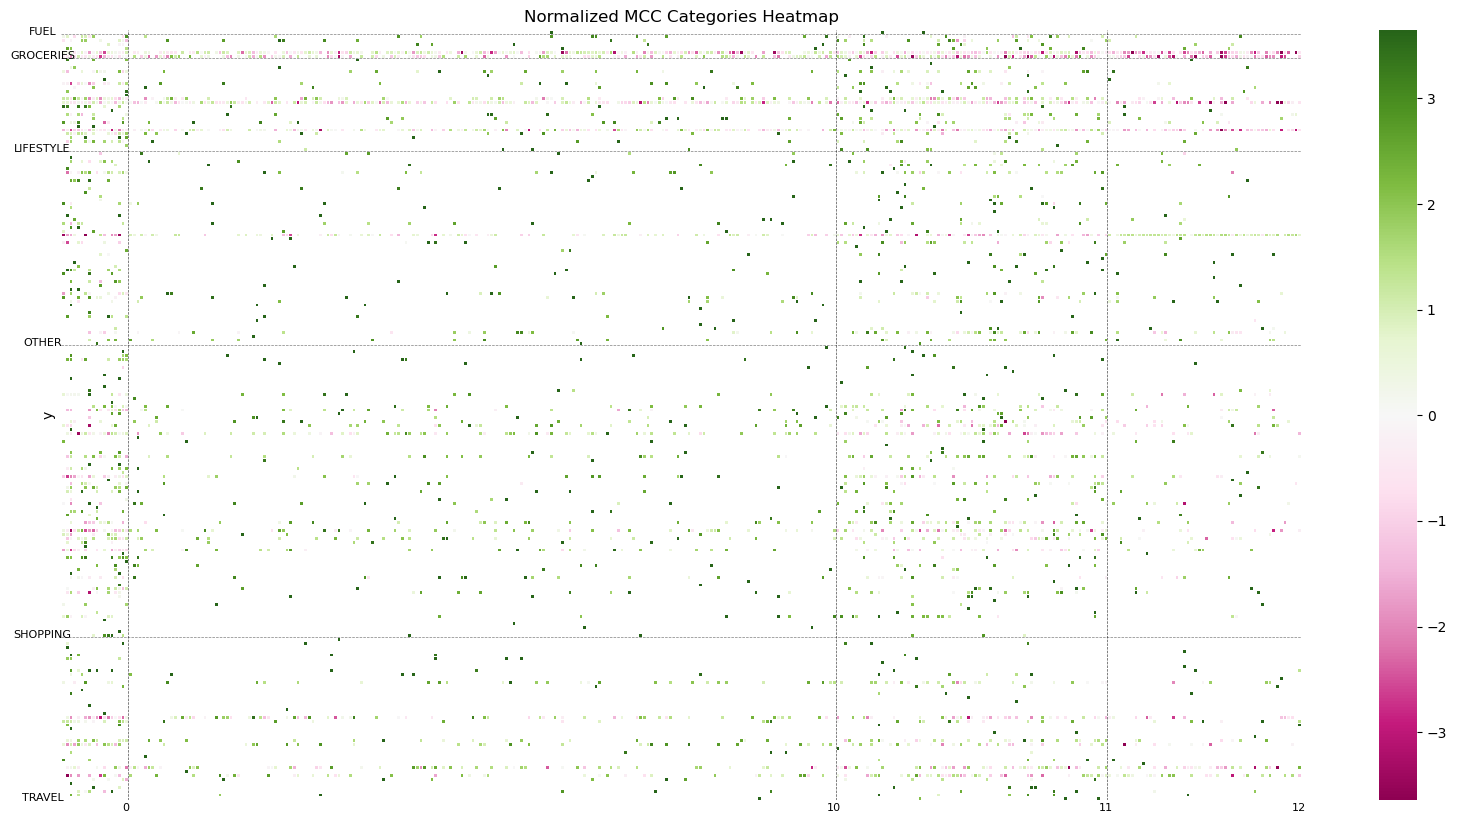

In [186]:
heatmaps_new(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory','MCC_List'], xvalues=['level_1','levels'], level_detail=False, value='amount')

/home/weiz/anaconda3/envs/network/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


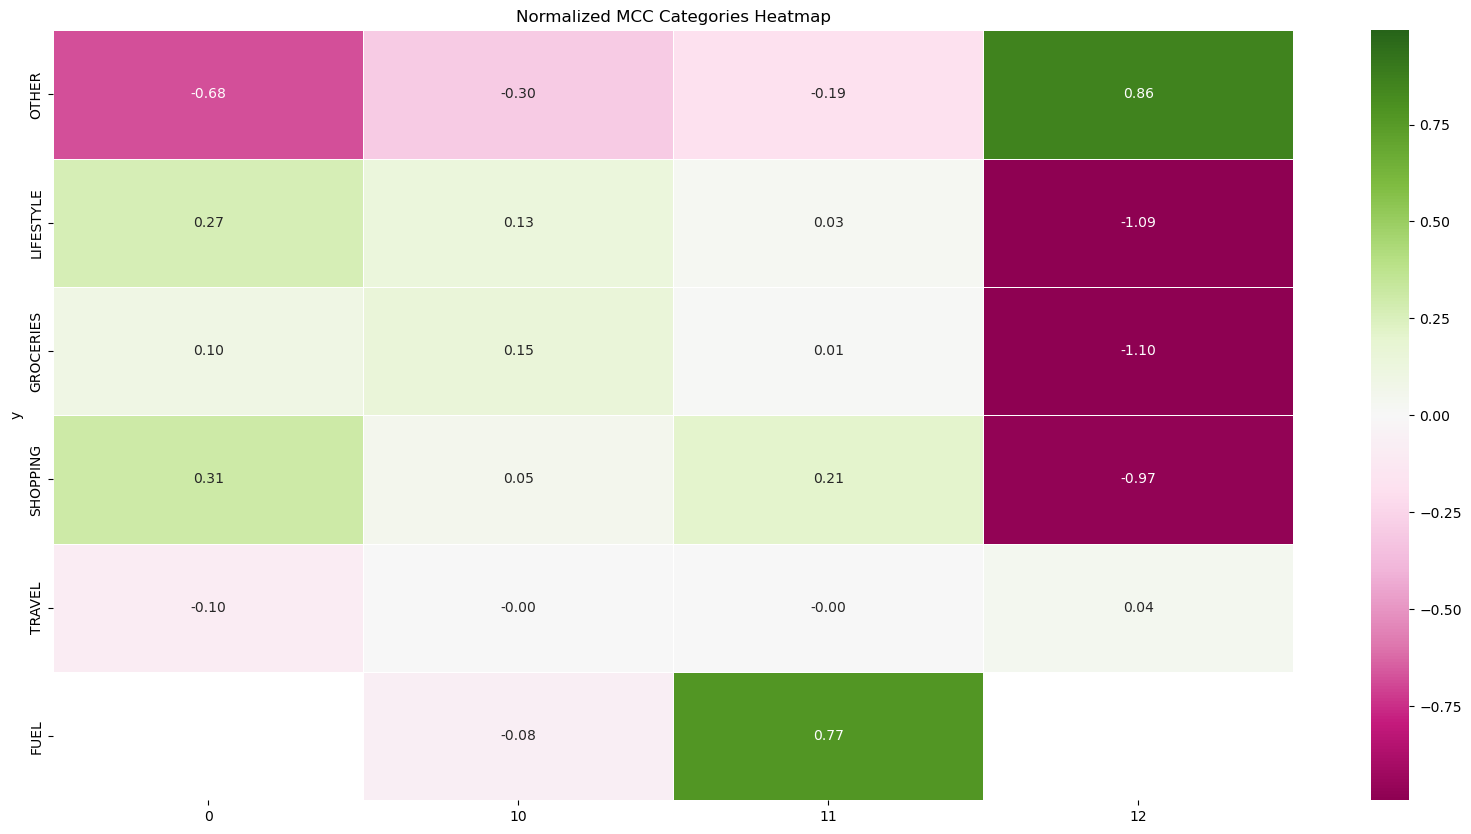

In [187]:
heatmaps_new(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

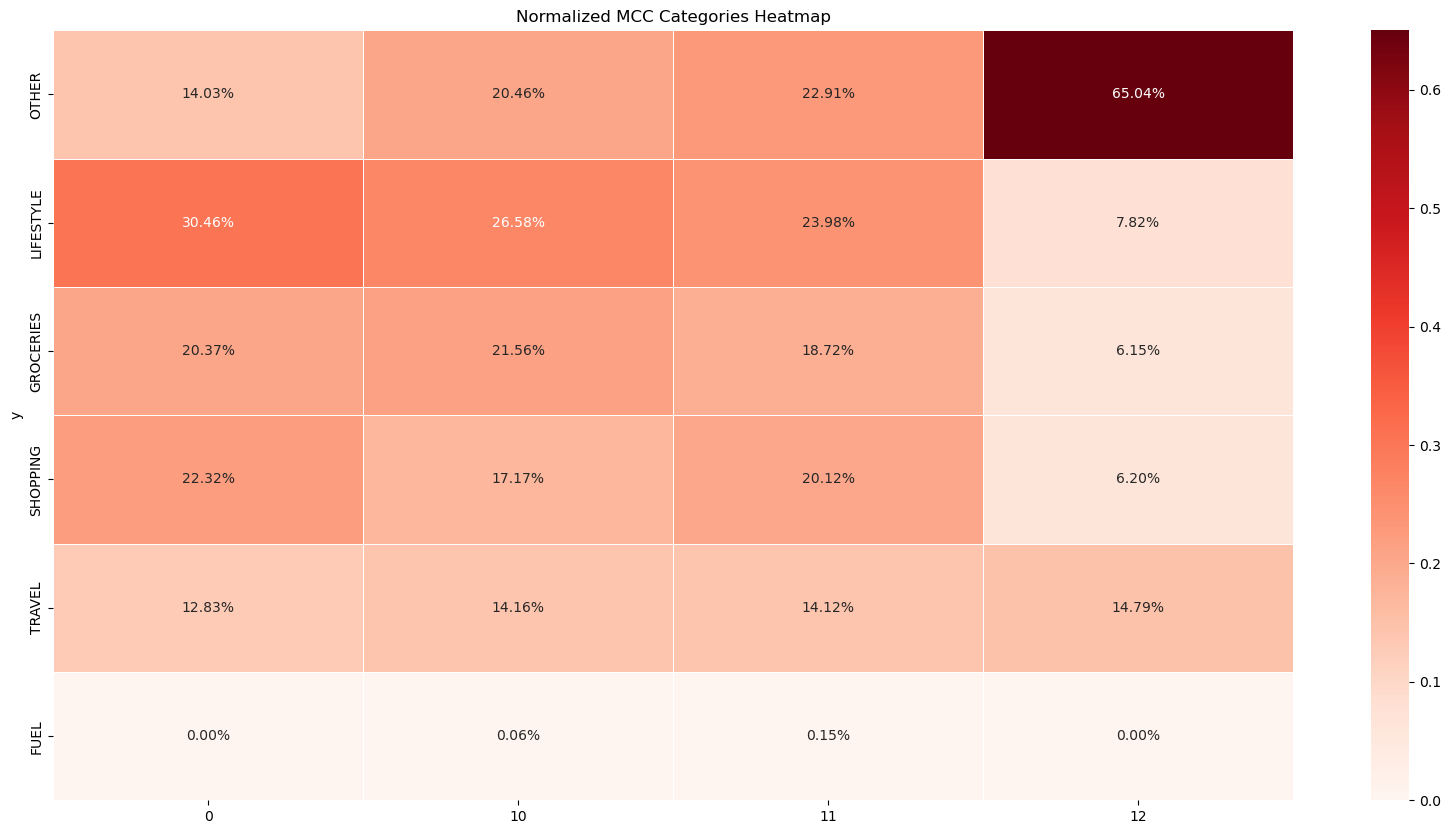

In [190]:
heatmaps_new(df_clusters, filtered_data, relative=False, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

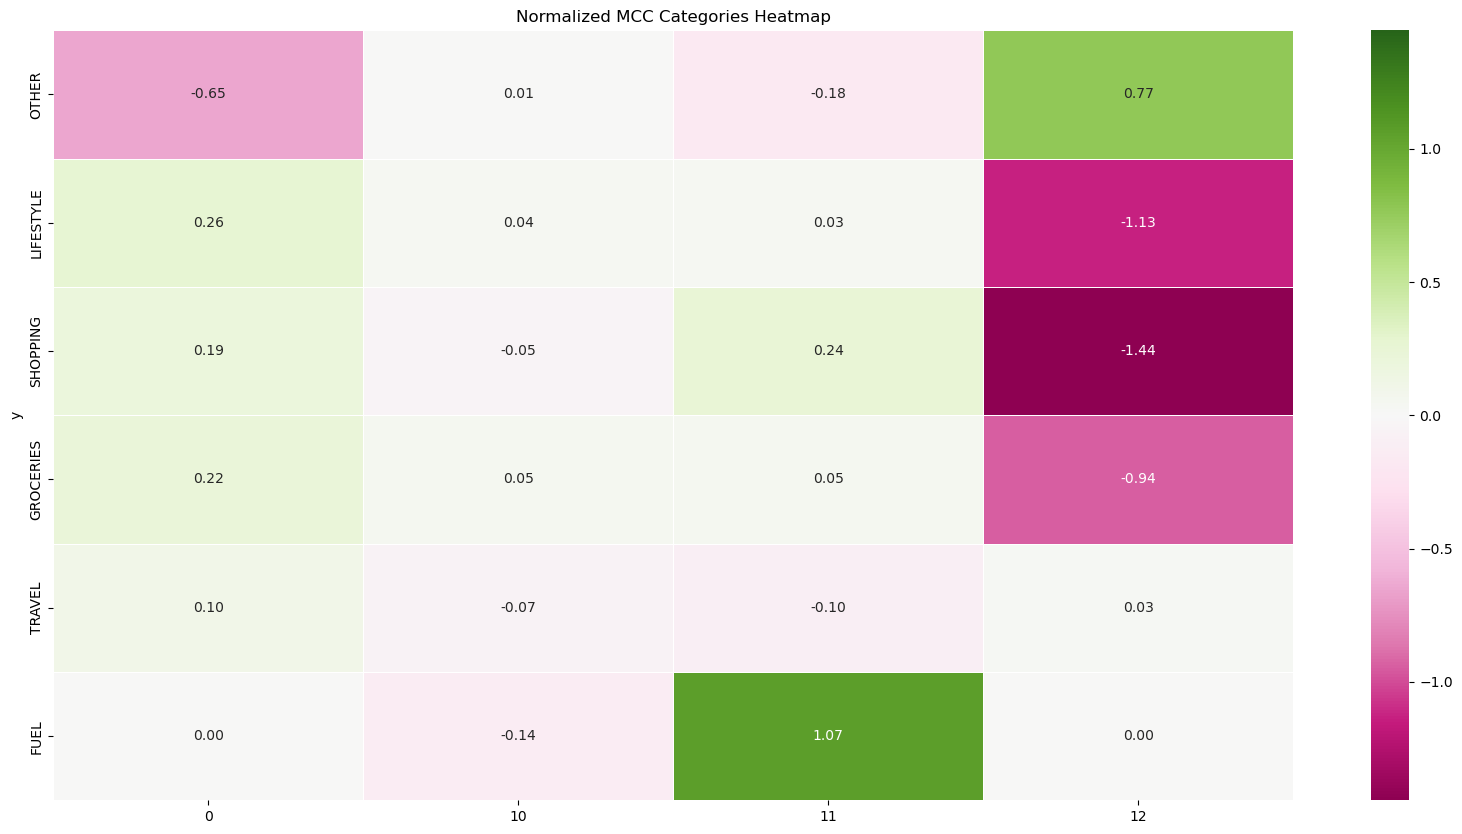

In [67]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

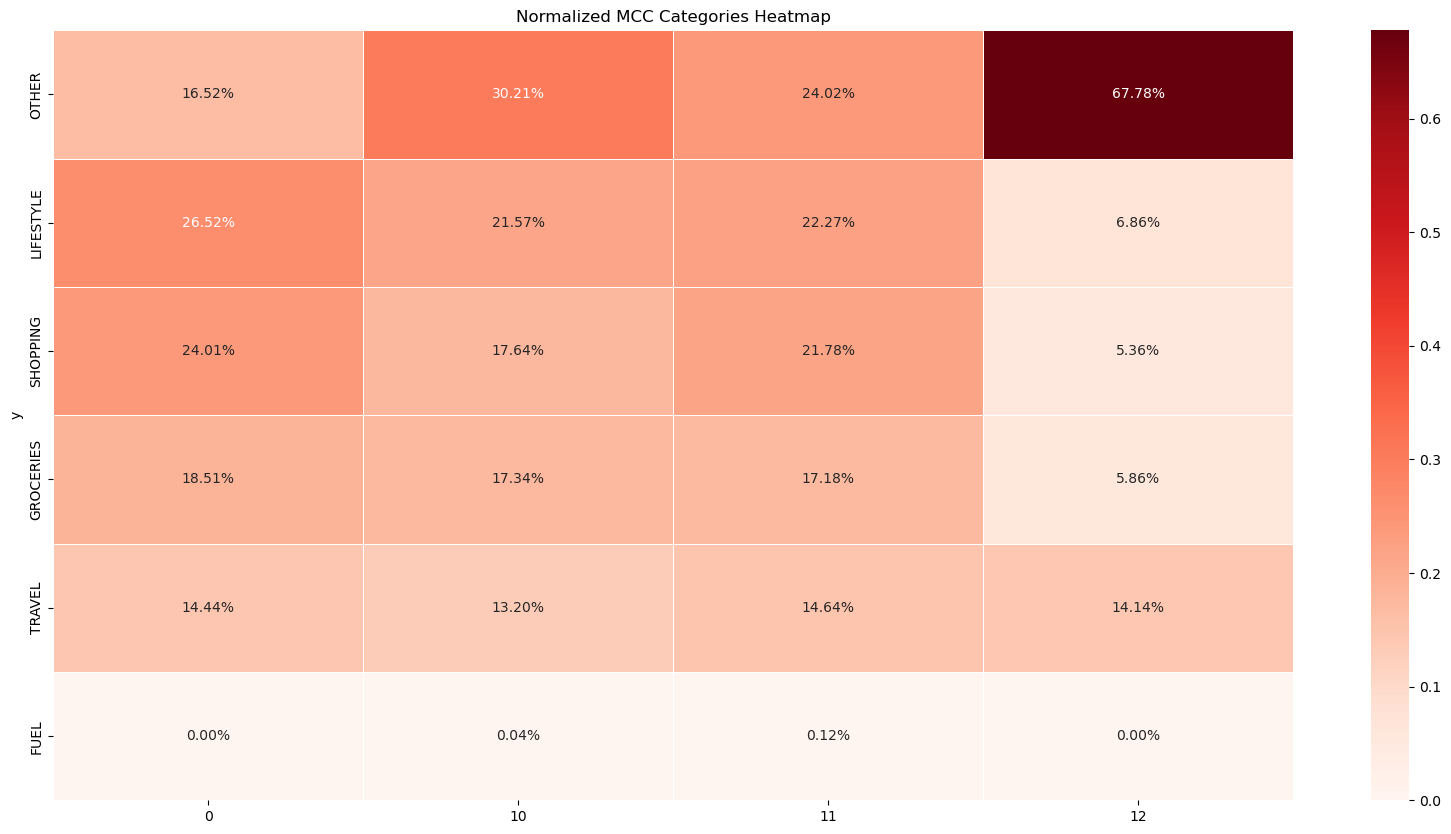

In [143]:
heatmaps(df_clusters, filtered_data, relative=False, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='amount', topn=6)

/home/weiz/anaconda3/envs/network/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


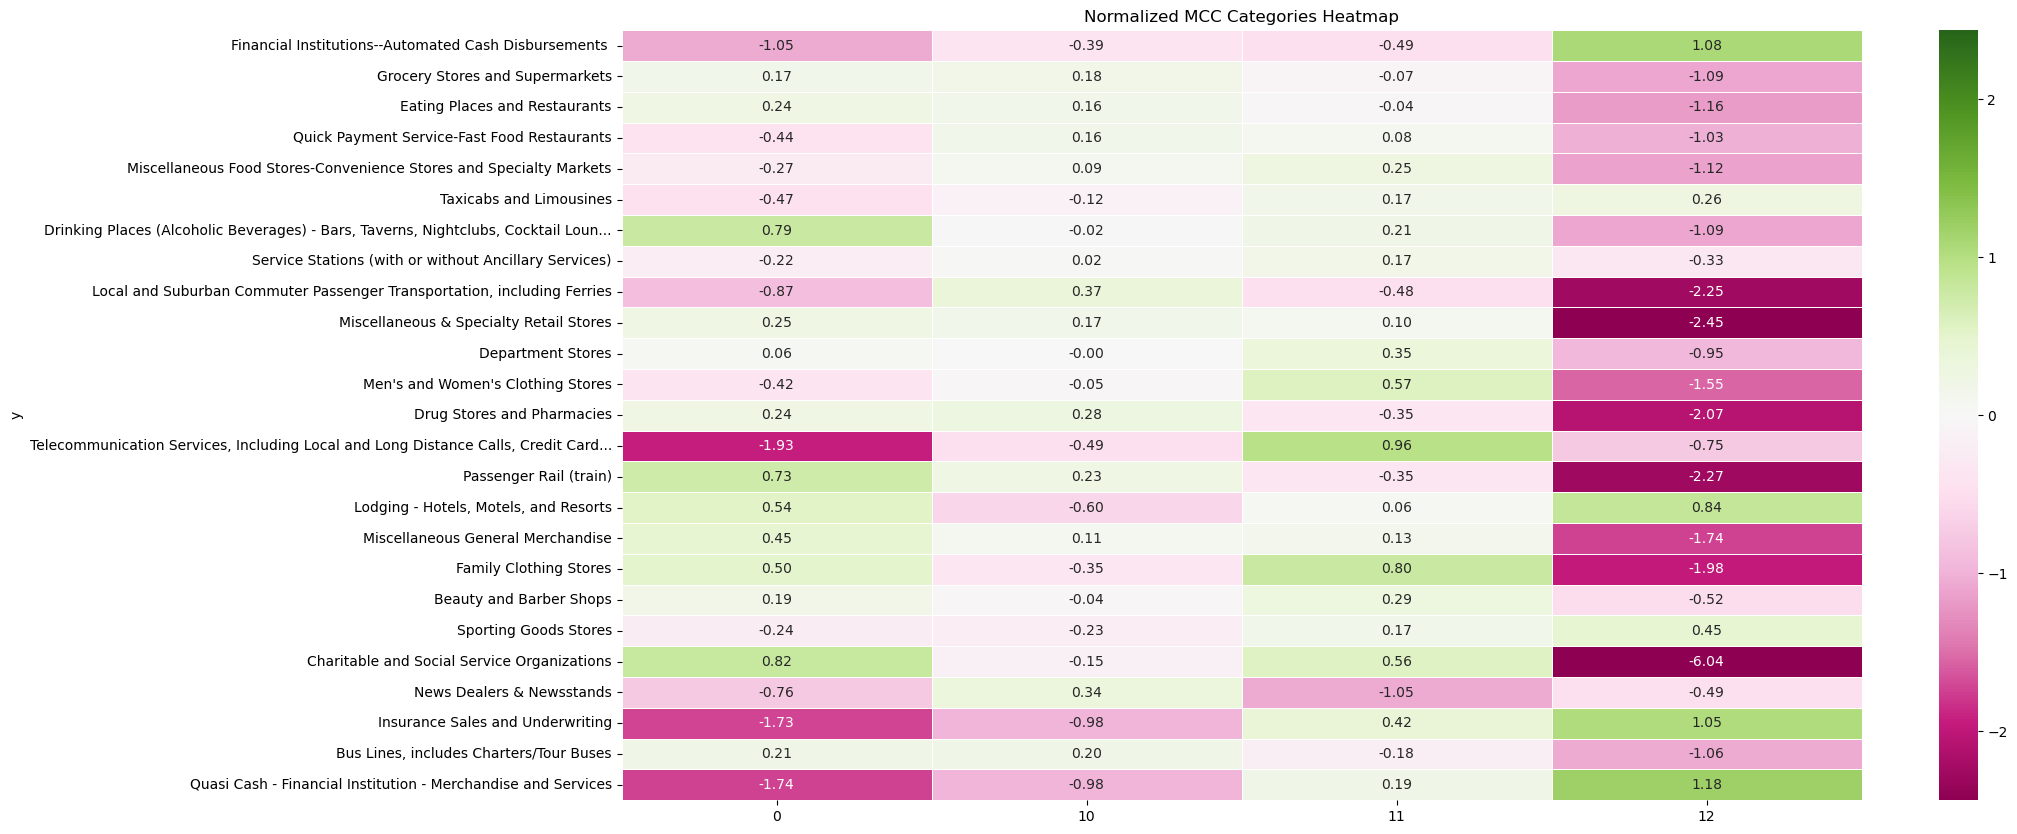

In [188]:
heatmaps_new(df_clusters, filtered_data, relative=True, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='amount', topn=25, max_label_len=80)

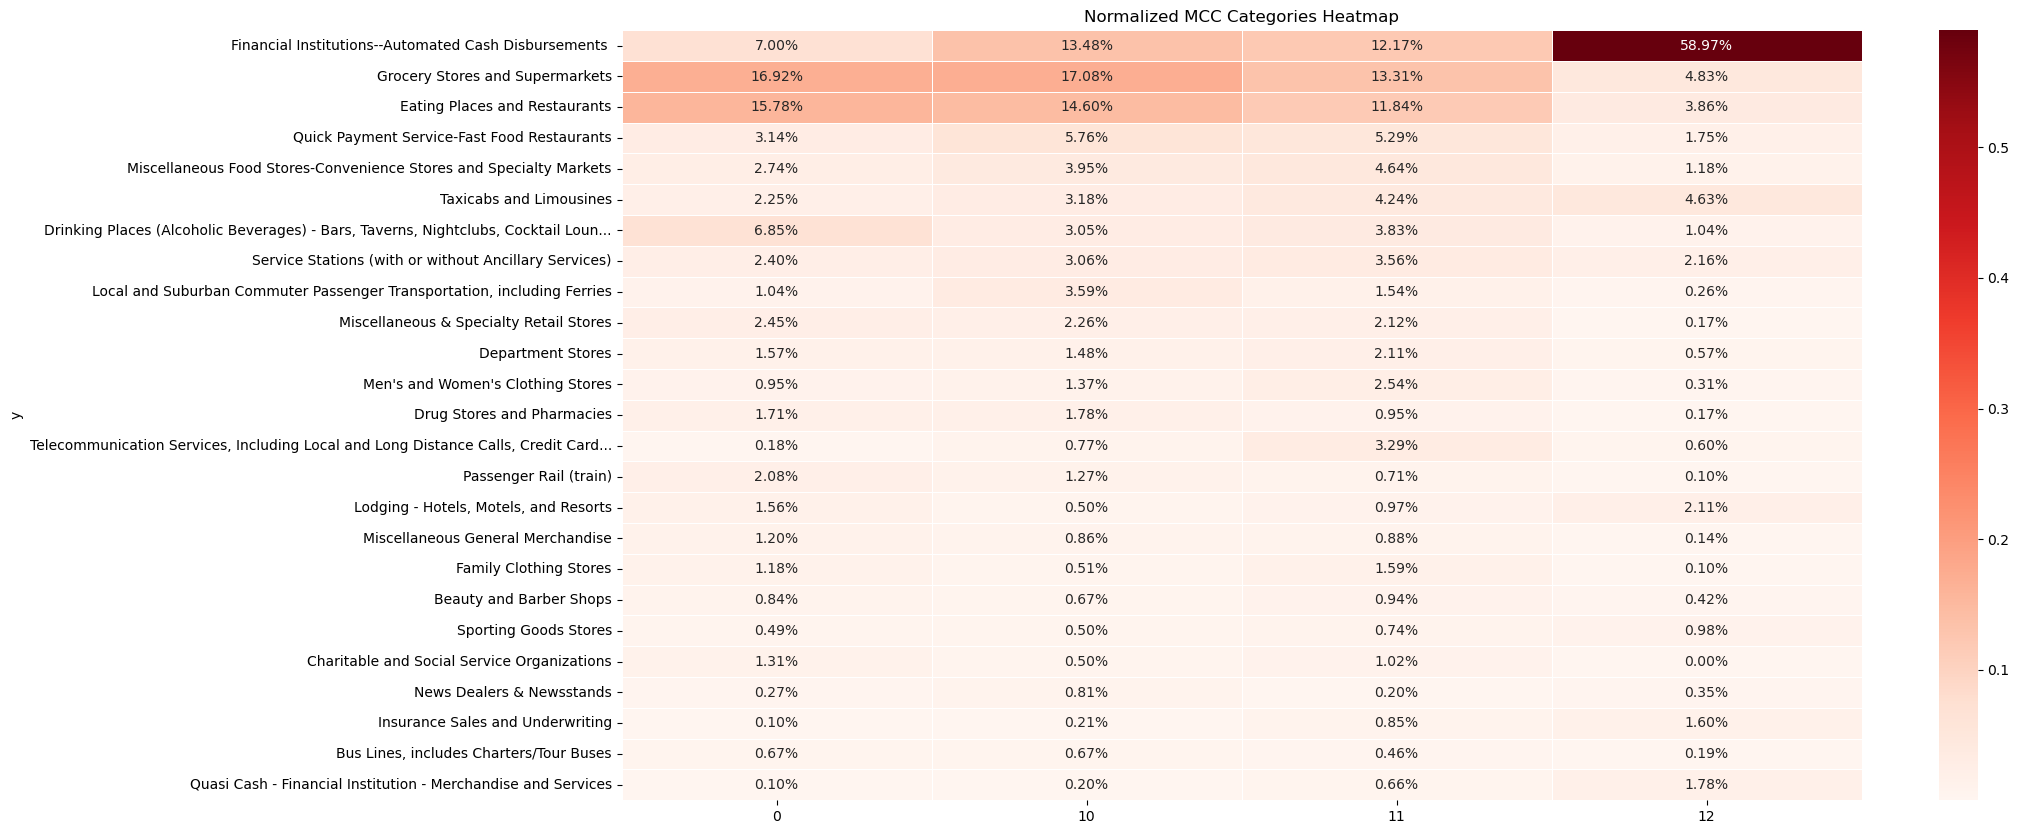

In [189]:
heatmaps_new(df_clusters, filtered_data, relative=False, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='amount', topn=25, max_label_len=80)

# clustering result analysis

## basic customers statistics

In [253]:
df_imd = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='IMD_Rank')
df_imd.drop_duplicates(subset='CustomerId', inplace=True)
df_customer = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='ekko_customer_info')

df_imd.dropna(inplace=True)
df_imd.reset_index(drop=True, inplace=True)
df_customer.dropna(inplace=True)
df_customer.reset_index(drop=True, inplace=True)

df_code_to_city = pd.read_csv('/home/weiz/card_transaction_network/PCD_OA_LSOA_MSOA_LAD_MAY21_UK_LU.csv', encoding='latin1', usecols=range(13))

df_imd['city'] = df_imd['LSOA_code'].map(df_code_to_city.groupby('lsoa11cd')['ladnm'].agg('first'))

# calculate the age of the customers
df_customer['age'] = df_customer.apply(lambda x: 2024 - parser.parse(x['dateOfBirth']).year, axis=1)

df_customer.head()

Sender_customer_Id address.postcode address.townOrCity  \
0  eecbba00-41c0-4111-ae83-286a302fed0c          NW1 9DR             London   
1  dff827bc-d6bb-4fd0-ae3d-d82786f9e5ad          SM2 6DU             Sutton   
2  bb10d50e-5e6a-43c2-bd6d-323b7d9c731f          SW1W0NY             London   
3  5c0a9926-a3b5-4441-945b-c1f619ed339a           SM25HT             Sutton   
4  12ea2e69-cea2-4e47-9d21-55402dd47811          SW1W0NY             London   

                  createdAt               dateOfBirth     nationality  age  
0  2021-11-04T12:46:07.257Z  1995-05-21T00:00:00.000Z  United Kingdom   29  
1  2021-12-09T18:04:46.294Z  1981-10-30T00:00:00.000Z  United Kingdom   43  
2  2021-12-15T11:41:54.937Z  1991-04-11T00:00:00.000Z  United Kingdom   33  
3  2021-12-15T13:33:27.821Z  1986-05-22T00:00:00.000Z  United Kingdom   38  
4  2021-12-15T14:31:52.354Z  1991-04-11T00:00:00.000Z  United Kingdom   33

In [254]:
df_imd['age'] = df_imd['CustomerId'].map(df_customer.set_index('Sender_customer_Id')['age'])
df_imd.head()

CustomerId  Index_of_Multiple_Deprivation_Decile  \
0  db9b8ecb-173d-43fb-bff6-b7f7b54b603b                                     3   
1  60614561-6838-4200-a37c-978cdffad096                                     2   
2  886926ad-2f76-4746-a7fc-ca1473c848a3                                     9   
3  55929e08-6995-4766-ad89-402bb47358f8                                     4   
4  ae54b0a2-7ad3-432c-ae1b-040e9365f8ee                                     7   

  Postcode_Status  LSOA_code                   LSOA_Name  \
0            Live  E01010959   Calderdale 020D E01010959   
1            Live  E01011043     Kirklees 031B E01011043   
2            Live  E01004694  Westminster 016C E01004694   
3            Live  E01027498     Tynedale 005B E01027498   
4            Live  E01001642    Greenwich 038C E01001642   

   Index_of_Multiple_Deprivation_Rank  Income_Rank  Income_Decile  \
0                                8106         7040              3   
1                                5947         6529              2   
2                               26491        31488             10   
3                               12152         8097              3   
4                               22742        26579              9   

   Income_Score  Employment_Rank  ...  Living_Environment_Rank  \
0         0.194             5093  ...                     9666   
1         0.202             6750  ...                     1975   
2         0.026            32231  ...                     5526   
3         0.179             9178  ...                    32328   
4         0.048            30198  ...                     6012   

   Living_Environment_Decile  IDACI_Rank  IDACI_Decile  IDACI_Score  \
0                          3        6327             2        0.260   
1                          1        9700             3        0.206   
2                          2       32013            10        0.019   
3                         10        9016             3        0.216   
4                          2       21946             7        0.082   

   IDAOPI_Rank  IDAOPI_Decile  IDAOPI_Score            city   age  
0        12134              4         0.172      Calderdale  29.0  
1         3799              2         0.324        Kirklees  26.0  
2        19729              7         0.102     Westminster  27.0  
3         7387              3         0.241  Northumberland  28.0  
4        25719              8         0.067       Greenwich  56.0  

[5 rows x 30 columns]

In [255]:
df_imd.shape

(873, 30)

In [257]:
df_clusters['imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Index_of_Multiple_Deprivation_Decile'])
df_clusters['age'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['age'])
df_clusters['edu_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Education_and_Skills_Decile'])
df_clusters['health_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Health_and_Disability_Decile'])
df_clusters['crime_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Crime_Decile'])
df_clusters['bhs_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Barriers_to_Housing_and_Services_Decile'])
df_clusters['living_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['Living_Environment_Decile'])
df_clusters['IDACI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDACI_Decile'])
df_clusters['IDAOPI_imd'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['IDAOPI_Decile'])
df_clusters['city'] = df_clusters['node'].map(df_imd.set_index('CustomerId')['city'])

In [258]:
df_clusters.isna().sum()

node           0
kind           0
level_1        0
level_0        0
levels         0
imd           49
age           60
edu_imd       49
health_imd    49
crime_imd     49
bhs_imd       49
living_imd    49
IDACI_imd     49
IDAOPI_imd    49
city          49
dtype: int64

In [280]:
df_corr = df_clusters.copy()
df_corr.dropna(inplace=True)
print(df_corr.shape)
df_corr.isna().sum()

(273, 15)


node          0
kind          0
level_1       0
level_0       0
levels        0
imd           0
age           0
edu_imd       0
health_imd    0
crime_imd     0
bhs_imd       0
living_imd    0
IDACI_imd     0
IDAOPI_imd    0
city          0
dtype: int64

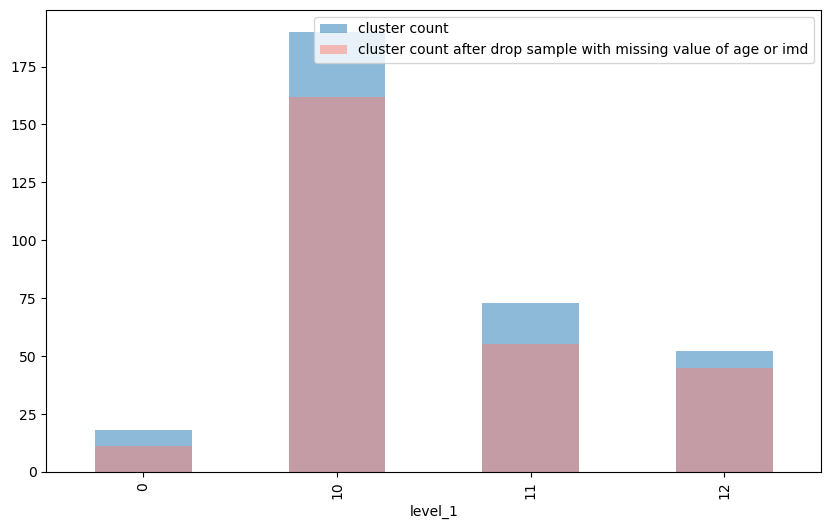

In [381]:
# plot the cluster count from both df_clusters and df_corr on the same plot
plt.figure(figsize=(10, 6))
df_clusters['level_1'].value_counts().sort_index().plot(kind='bar', alpha=0.5, label='cluster count')
df_corr['level_1'].value_counts().sort_index().plot(kind='bar', alpha=0.5, label='cluster count after drop sample with missing value of age or imd', color='salmon')
plt.legend()
plt.show()
# df_clusters['level_1'].value_counts().sort_index().plot(kind='bar')
# df_corr['level_1'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='level_1'>

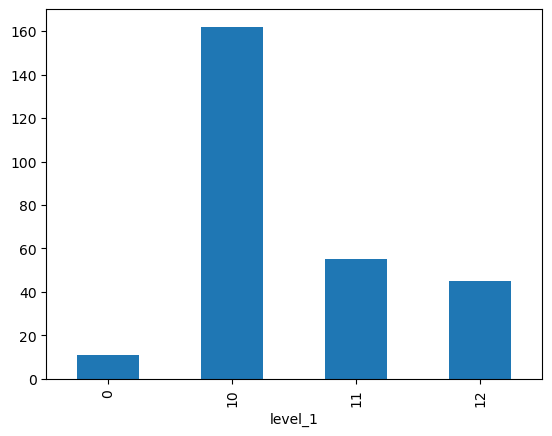

In [282]:
df_corr['level_1'].value_counts().sort_index().plot(kind='bar')

In [283]:
df_corr['level_1'].value_counts().sort_index()/df_clusters['level_1'].value_counts().sort_index()

level_1
0     0.611111
10    0.852632
11    0.753425
12    0.865385
Name: count, dtype: float64

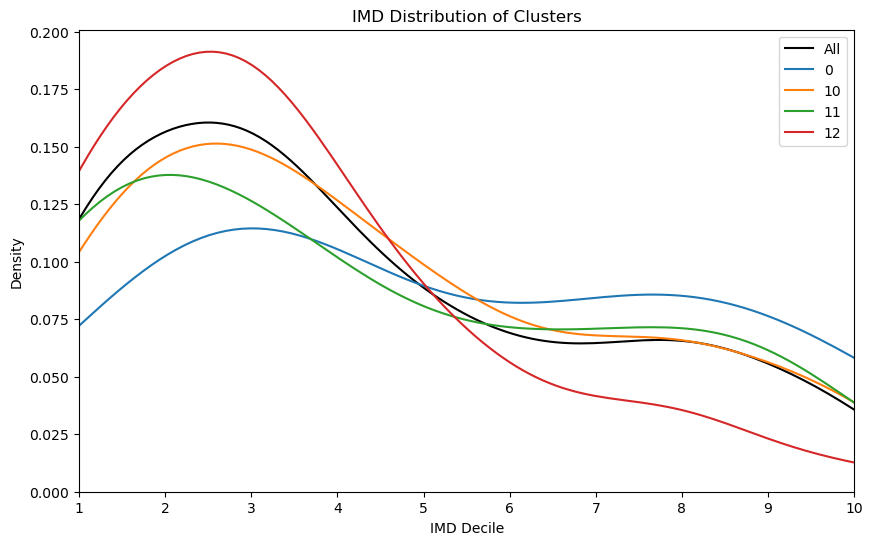

In [284]:
# plot the probability distribution of imd for each cluster and the whole population
plt.figure(figsize=(10, 6))
sns.kdeplot(df_corr['imd'], label='All', color='black')
plt.xlim(1, 10)
for cluster in df_corr['level_1'].unique():
    sns.kdeplot(df_corr[df_corr['level_1'] == cluster]['imd'], label=cluster)
plt.title('IMD Distribution of Clusters')
plt.xlabel('IMD Decile')
plt.ylabel('Density')
plt.legend()
plt.show()

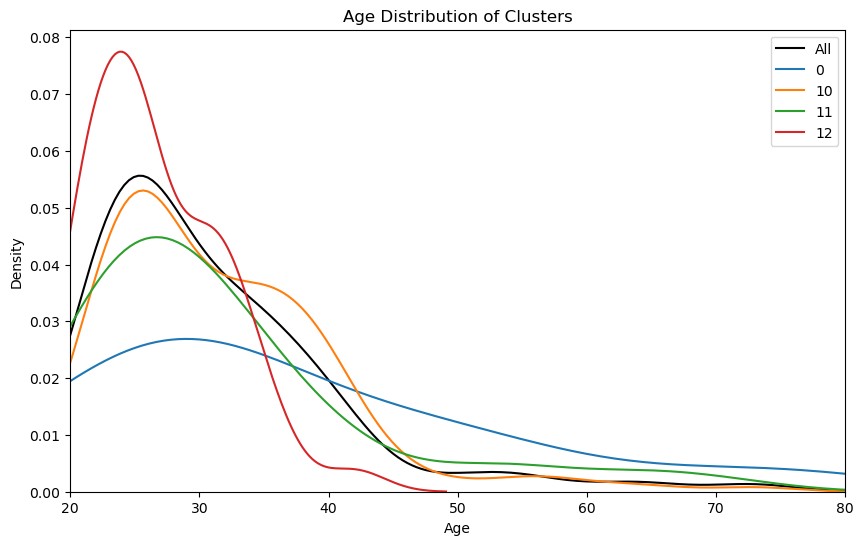

In [285]:
# plot the probability distribution of age for each cluster and the whole population
plt.figure(figsize=(10, 6))
sns.kdeplot(df_corr['age'], label='All', color='black')
plt.xlim(20, 80)
for cluster in df_corr['level_1'].unique():
    sns.kdeplot(df_corr[df_corr['level_1'] == cluster]['age'], label=cluster)
plt.title('Age Distribution of Clusters')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

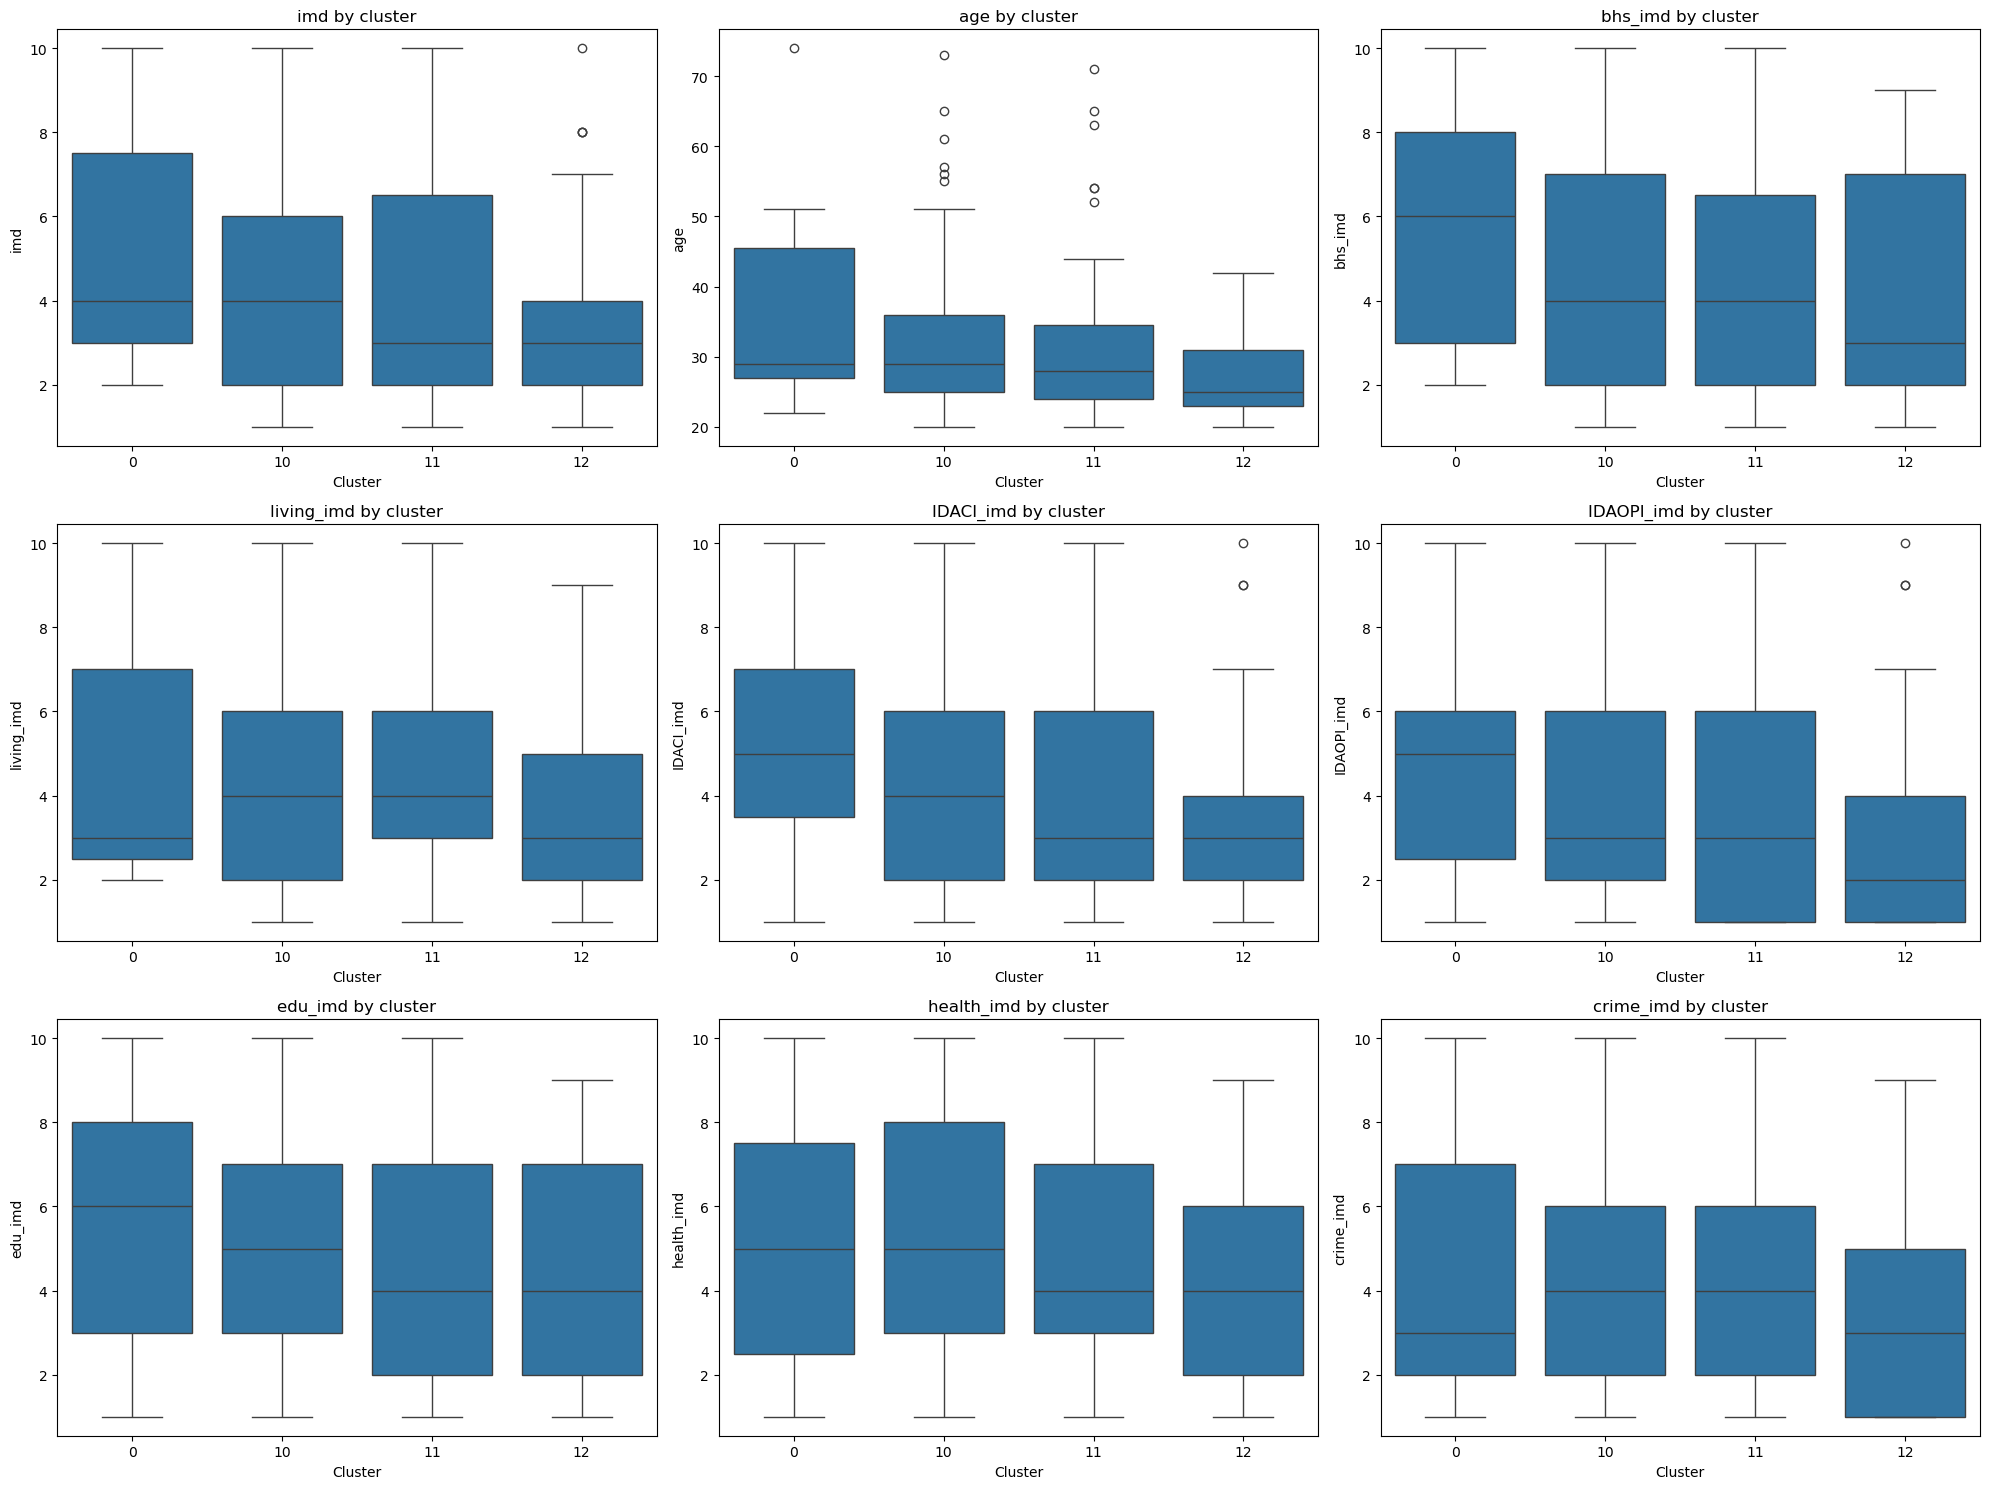

In [389]:
# plot the distribution of each feature for each cluster in a plot of 2x3
features = ['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd', 'edu_imd', 'health_imd', 'crime_imd']
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
for i, feature in enumerate(features):
    sns.boxplot(x='level_1', y=feature, data=df_corr, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{feature} by cluster')
    axes[i//3, i%3].set_xlabel('Cluster')
    axes[i//3, i%3].set_ylabel(feature)
plt.tight_layout()
plt.show()

In [390]:
# Kruskal-Wallis test for each feature, to test if the distributions of the features are the same for each cluster
# if p-value < 0.05, the distributions are different
features = ['imd', 'age', 'bhs_imd', 'living_imd', 'IDACI_imd', 'IDAOPI_imd', 'edu_imd', 'health_imd', 'crime_imd']
for feature in features:
    print('Feature:', feature)
    kw, p = stats.kruskal(*[df_corr[df_corr['level_1'] == cluster][feature] for cluster in df_corr['level_1'].unique()])
    print('Kruskal-Wallis Test: ', np.round(kw, 4), 'p-value: ', np.round(p, 4))
    # print(stats.kruskal(*[df_corr[df_corr['level_1'] == cluster][feature] for cluster in df_corr['level_1'].unique()]))
    print()

Feature: imd
Kruskal-Wallis Test:  6.0733 p-value:  0.1081

Feature: age
Kruskal-Wallis Test:  15.4564 p-value:  0.0015

Feature: bhs_imd
Kruskal-Wallis Test:  3.1256 p-value:  0.3727

Feature: living_imd
Kruskal-Wallis Test:  1.9072 p-value:  0.5919

Feature: IDACI_imd
Kruskal-Wallis Test:  6.7565 p-value:  0.0801

Feature: IDAOPI_imd
Kruskal-Wallis Test:  7.6194 p-value:  0.0546

Feature: edu_imd
Kruskal-Wallis Test:  3.5266 p-value:  0.3173

Feature: health_imd
Kruskal-Wallis Test:  4.2005 p-value:  0.2406

Feature: crime_imd
Kruskal-Wallis Test:  2.9991 p-value:  0.3918



In [289]:
df_customer['address.townOrCity'].value_counts(normalize=True)

address.townOrCity
London        0.211382
Birmingham    0.040818
Manchester    0.036543
Leicester     0.023552
Leeds         0.018104
                ...   
Kilwinning    0.000084
Lutton        0.000084
Tetbury       0.000084
Lanark        0.000084
Canary        0.000084
Name: proportion, Length: 975, dtype: float64

In [290]:
df_clusters['city'].value_counts(normalize=True)

city
Southwark        0.049296
Brent            0.031690
Tower Hamlets    0.028169
Birmingham       0.028169
Sutton           0.024648
                   ...   
Exeter           0.003521
Gateshead        0.003521
Stevenage        0.003521
West Devon       0.003521
Stroud           0.003521
Name: proportion, Length: 121, dtype: float64

In [291]:
df_clusters['city1'] = df_clusters['node'].map(df_customer.set_index('Sender_customer_Id')['address.townOrCity'])
df_clusters['city1'].value_counts(normalize=True)

city1
London               0.240506
Birmingham           0.028481
Leicester            0.025316
Manchester           0.025316
Leeds                0.018987
                       ...   
Ashton-under-Lyne    0.003165
Warrington           0.003165
West Drayton         0.003165
Erith                0.003165
Woking               0.003165
Name: proportion, Length: 144, dtype: float64

In [295]:
df_lsoa = pd.read_csv('/home/weiz/card_transaction_network/NSPL_Online_Centroids_2400086033526942602.csv', usecols=['LSOA11','LAT','LONG','x','y'])
df_lsoa = df_lsoa.groupby('LSOA11').agg('mean').reset_index()
df_lsoa.head()

LSOA11        LAT      LONG              x              y
0  95AA01S1  54.652277 -6.212622  128368.528191  536729.356325
1  95AA01S2  54.637764 -6.240735  126454.517075  535224.457876
2  95AA01S3  54.688029 -6.183681  130471.297137  540592.642585
3  95AA02W1  54.709040 -6.221521  128174.776802  543074.385934
4  95AA03W1  54.706897 -6.183591  130602.334731  542689.770679

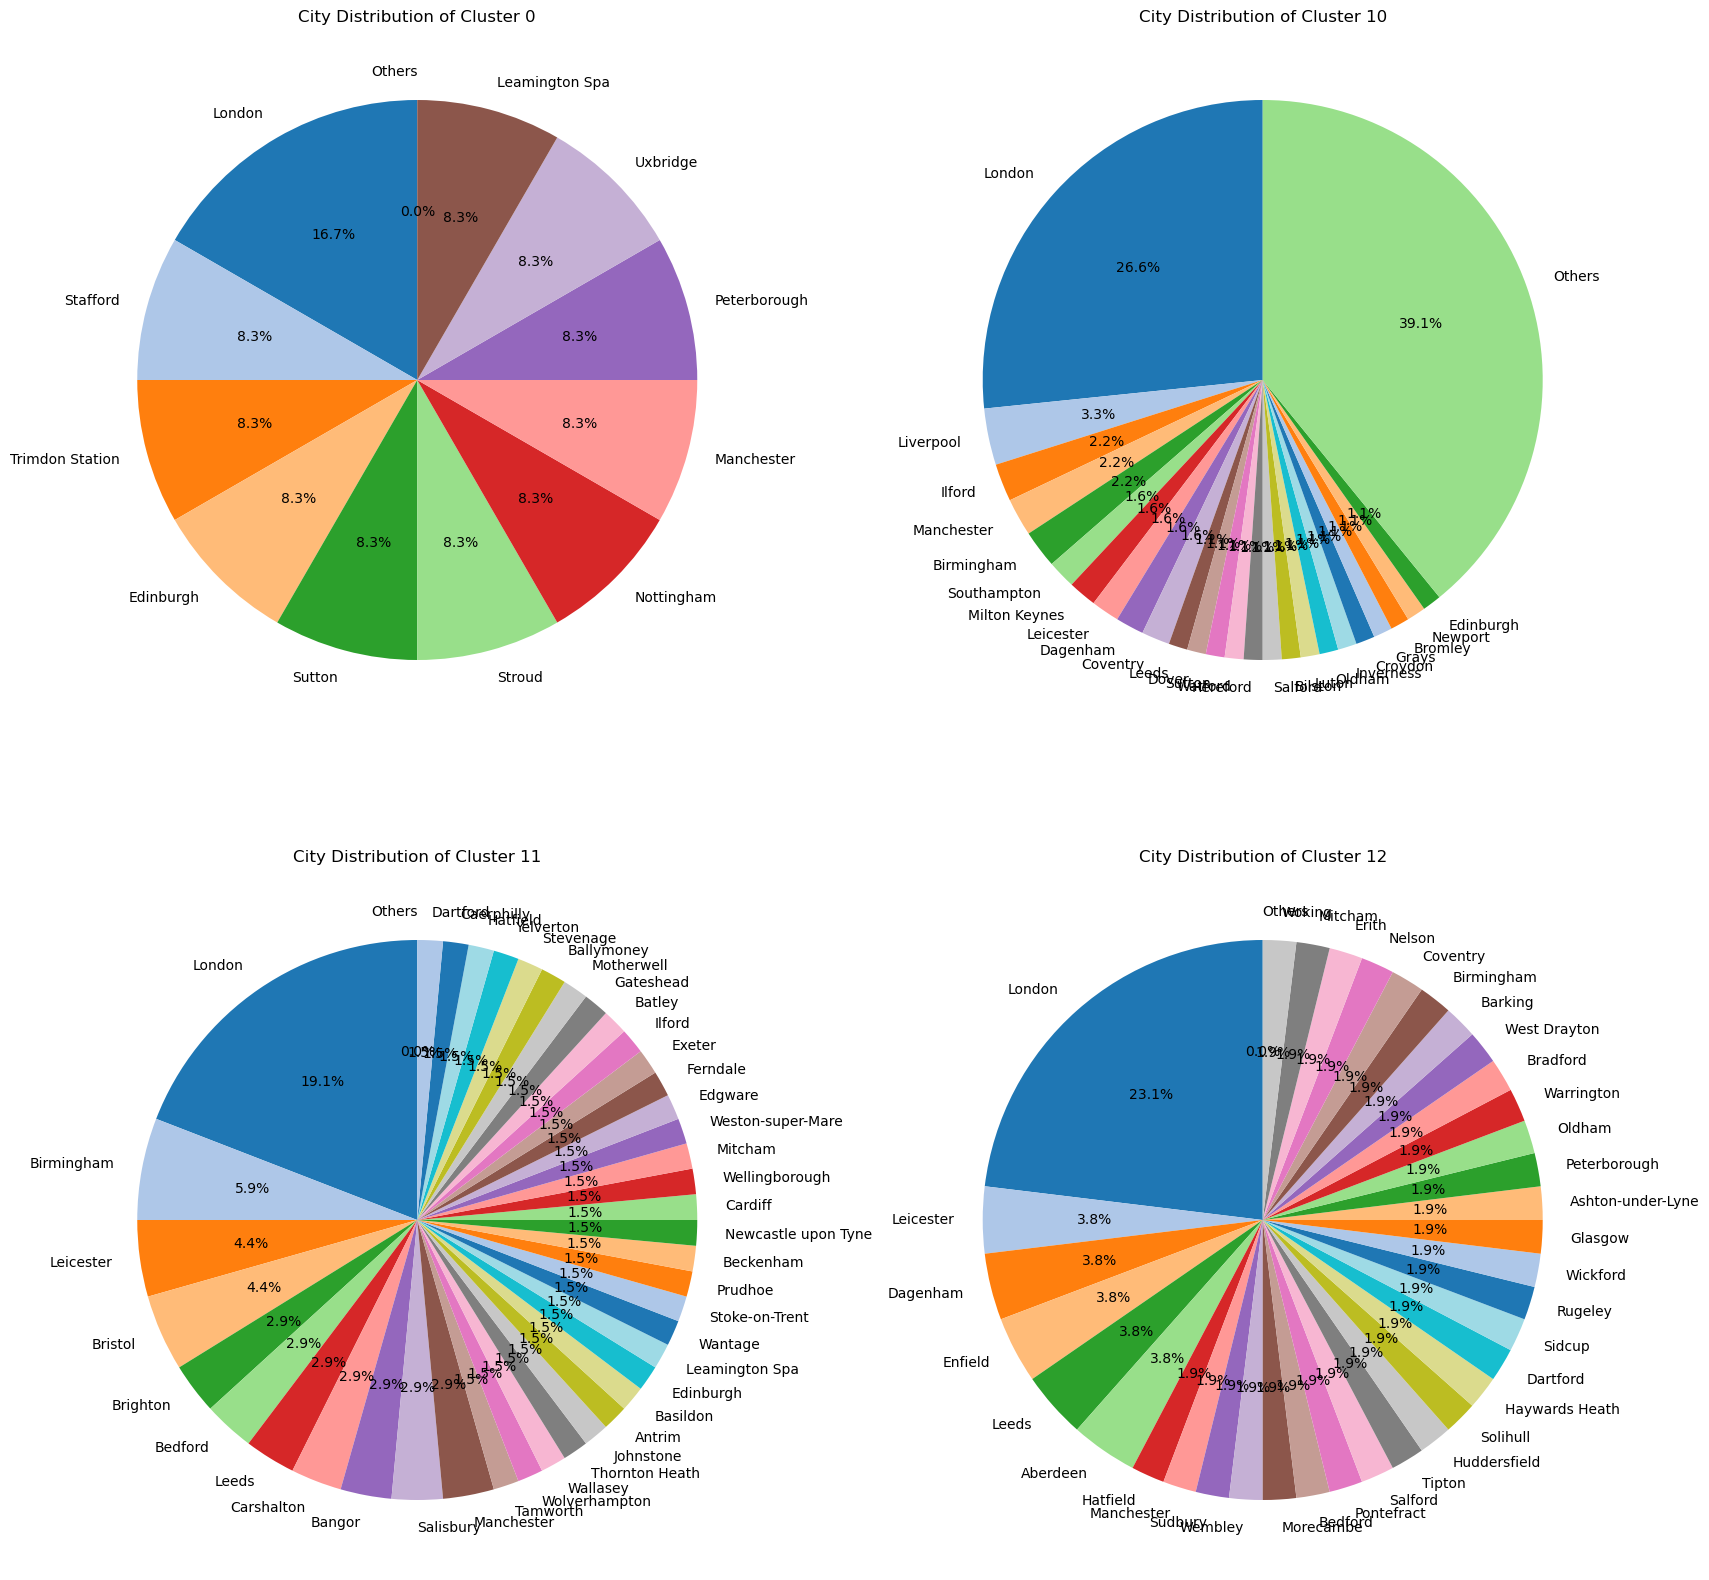

In [309]:
# plot pie chart of the city distribution for each cluster
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, cluster in enumerate(df_clusters['level_1'].unique()):
    df_city = df_clusters[df_clusters['level_1'] == cluster]
    city_dist = df_city['city1'].value_counts(normalize=True)

    # merge the cities with no more than 1% of the total population into 'Others'
    other = city_dist[city_dist <= 0.01].sum()
    city_dist = city_dist[city_dist > 0.01]
    city_dist['Others'] = other
    axes[i//2, i%2].pie(city_dist, labels=city_dist.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('tab20'))
    axes[i//2, i%2].set_title(f'City Distribution of Cluster {cluster}')

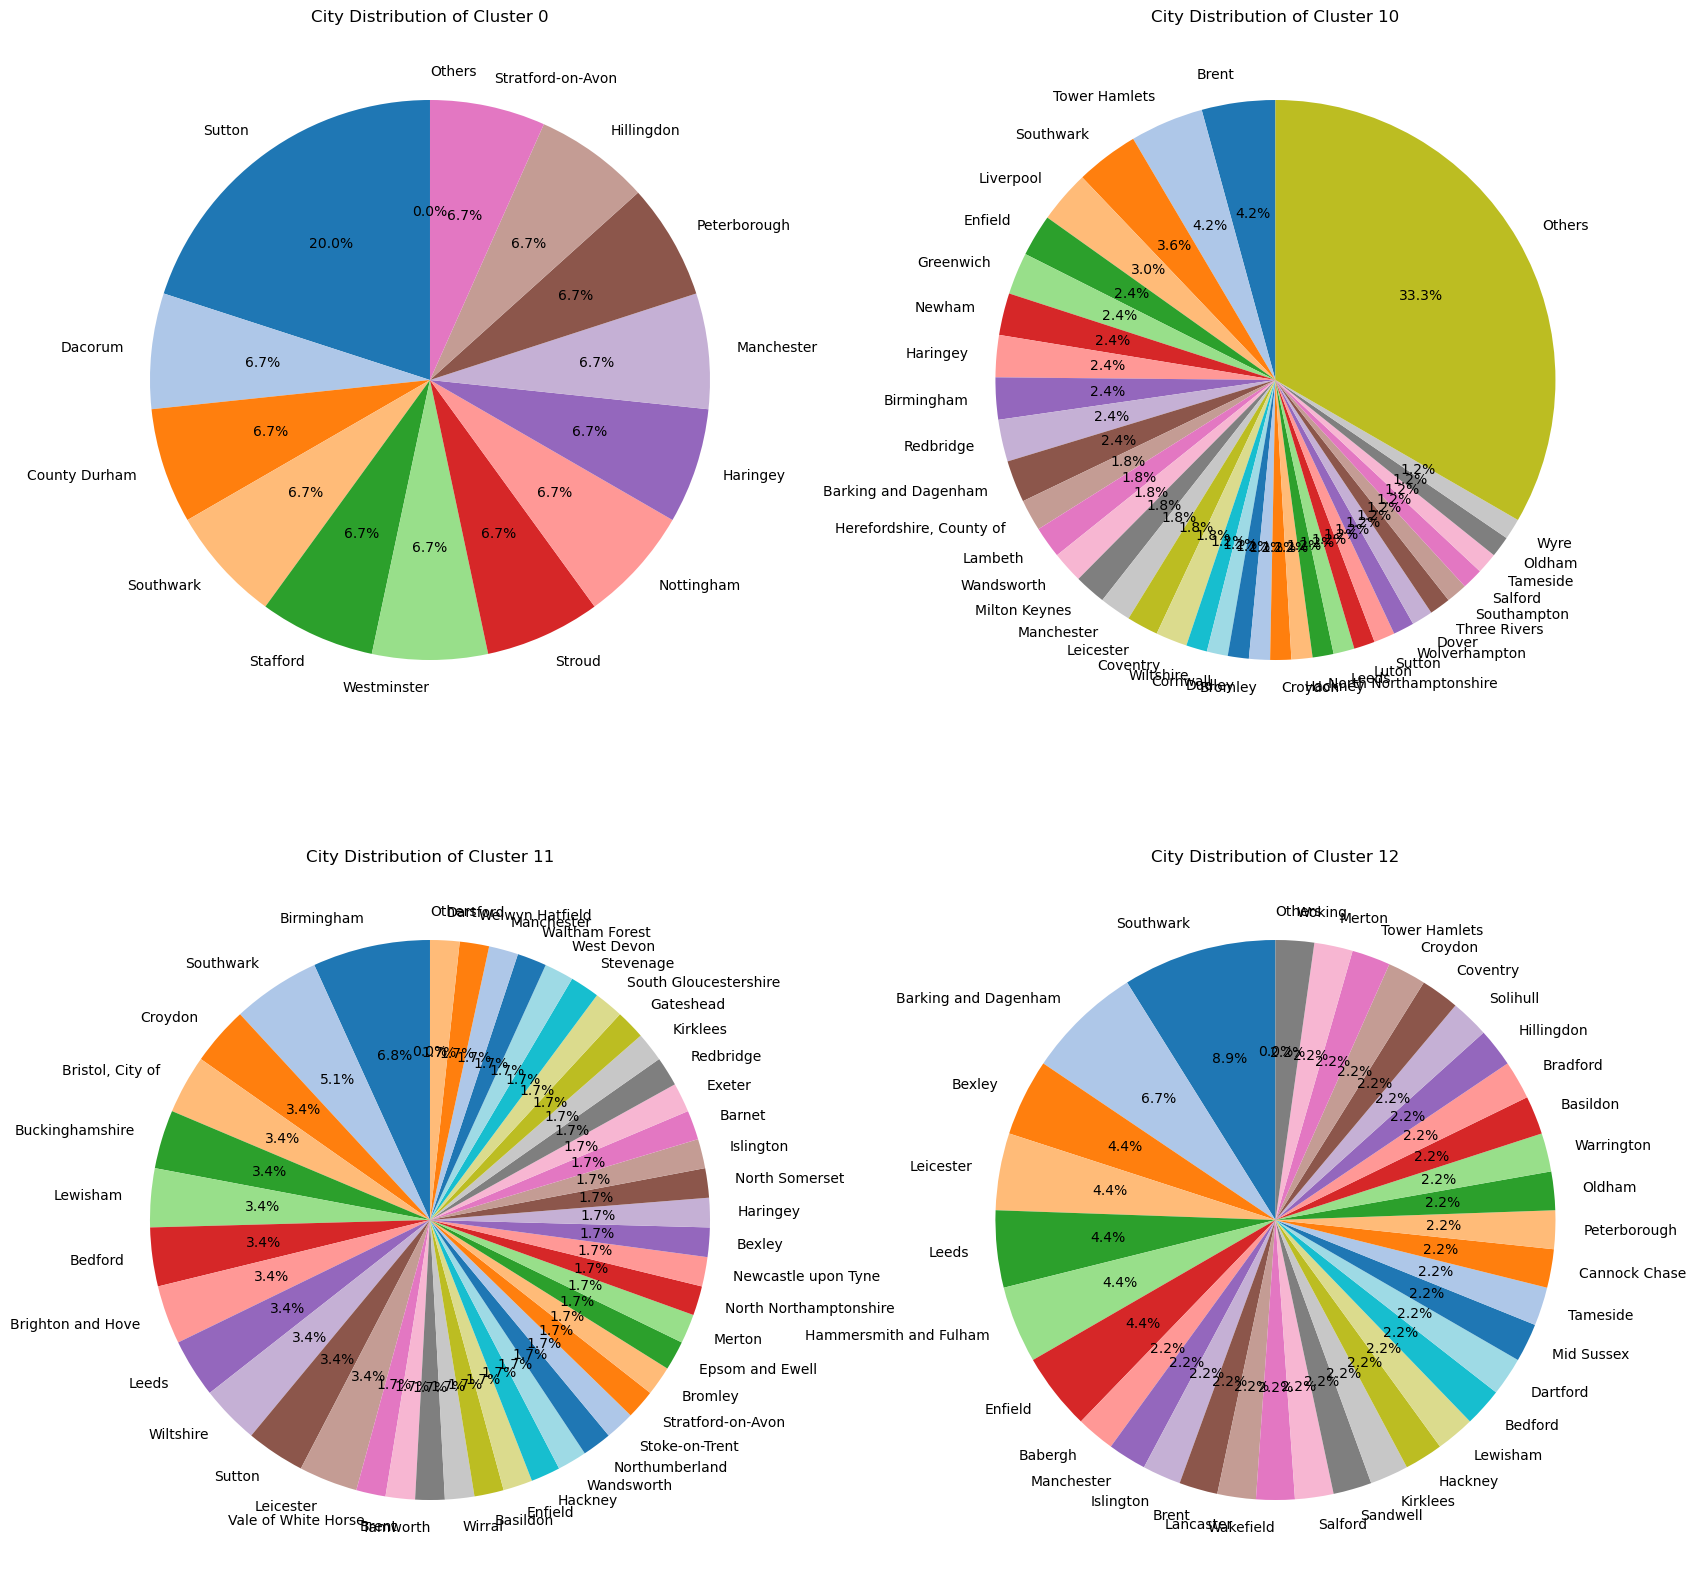

In [310]:
# plot pie chart of the city distribution for each cluster
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for i, cluster in enumerate(df_clusters['level_1'].unique()):
    df_city = df_clusters[df_clusters['level_1'] == cluster]
    city_dist = df_city['city'].value_counts(normalize=True)

    # merge the cities with no more than 1% of the total population into 'Others'
    other = city_dist[city_dist <= 0.01].sum()
    city_dist = city_dist[city_dist > 0.01]
    city_dist['Others'] = other
    axes[i//2, i%2].pie(city_dist, labels=city_dist.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('tab20'))
    axes[i//2, i%2].set_title(f'City Distribution of Cluster {cluster}')

In [321]:
# chi-square test for the city distribution of each cluster
# if p-value < 0.05, the distributions are different
contingency_table = pd.crosstab(df_clusters['level_1'], df_clusters['city'], normalize='columns')
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print('Chi-square:', chi2)
print('P-value:', p)

Chi-square: 240.31717448064018
P-value: 0.9999997844115266


In [322]:
# chi-square test for the city distribution of each cluster
# if p-value < 0.05, the distributions are different
contingency_table = pd.crosstab(df_clusters['level_1'], df_clusters['city1'], normalize='columns')
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print('Chi-square:', chi2)
print('P-value:', p)

Chi-square: 340.6432913866803
P-value: 0.9993798974535902


In [376]:
temp = (filtered_data.groupby(['externalParty.transactionCategory', 'MCC_List'])['amount.value'].sum()/filtered_data.groupby('externalParty.transactionCategory')['amount.value'].sum()).groupby('externalParty.transactionCategory').nlargest(5)
temp.reset_index(level=0, drop=True, inplace=True)
pd.DataFrame(temp)

amount.value
externalParty.transactionCategory MCC_List                                                        
FUEL                              Fuel Dealers--Fuel Oil, Wood, Coal, and Liquefi...      1.000000
GROCERIES                         Grocery Stores and Supermarkets                         0.774878
                                  Miscellaneous Food Stores-Convenience Stores an...      0.193926
                                  Bakeries                                                0.012929
                                  Candy, Nut, and Confectionary Stores                    0.010441
                                  Freezer & Locker Meat Provisions                        0.005046
LIFESTYLE                         Eating Places and Restaurants                           0.537684
                                  Quick Payment Service-Fast Food Restaurants             0.162687
                                  Drinking Places (Alcoholic Beverages) - Bars, T...      0.159329
                                  Beauty and Barber Shops                                 0.030148
                                  Recreation Services - Not Elsewhere Classified          0.017795
OTHER                             Financial Institutions--Automated Cash Disburse...      0.740317
                                  Telecommunication Services, Including Local and...      0.032878
                                  Insurance Sales and Underwriting                        0.024701
                                  Professional Services - Not Elsewhere Classified        0.022958
                                  Charitable and Social Service Organizations             0.021951
SHOPPING                          Miscellaneous & Specialty Retail Stores                 0.105295
                                  Department Stores                                       0.103145
                                  Men's and Women's Clothing Stores                       0.089598
                                  Computer Software Stores                                0.083556
                                  Family Clothing Stores                                  0.052413
TRAVEL                            Service Stations (with or without Ancillary Ser...      0.239064
                                  Taxicabs and Limousines                                 0.223966
                                  Local and Suburban Commuter Passenger Transport...      0.103440
                                  Lodging - Hotels, Motels, and Resorts                   0.077481
                                  Passenger Rail (train)                                  0.076334